# WGCNA Analysis

Here we perform a *Weighted Gene Correlation Network Analysis*


### Data

The input matrix: this is the RaceID `sc_object_RaceID.RDS` dataset that was sent via gmail with the title "Object".

The datasets that are processed in this notebook are checkpointed into RDS objects and are accessible at the Galaxy History [Adrian Salas WGCNA TOM Checkpoints](https://usegalaxy.eu/u/mehmet-tekman/h/adrian-salas-wgcna-tom-checkpoints), but not in the code repository due to size.


## Installation

(installation was extremely problematic, took more than half a day -- neither conda, nor install.packages worked, giving missing library errors that were partially solved by symlinking between environments (something you should never do))

Installation finally completeed when I created a conda environment consisting just of `jupyterlab` and then did a 
`BiocManager::install("WGCNA")` install making sure to update all libraries

The RaceID conda environment was not compatible with this environment, so I installed from github making sure not to update any ssl libraries in case it broke the already fragile environment


# Initial Start

In [11]:
library(WGCNA)
library(RaceID)
library(flashClust)

In [12]:
options(stringsAsFactors = FALSE);
enableWGCNAThreads()

Allowing parallel execution with up to 3 working processes.


In [13]:
sc <- readRDS('~/Downloads/sc_object_RaceID.RDS')

In [15]:
sc@expdata[1:10,1:10]

   [[ suppressing 10 column names ‘C81711_1’, ‘C81711_2’, ‘C81711_3’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                        
1010001B22Rik .        . . . . . . . . .
1700024B05Rik .        . . . . . . . . .
Cd209f        .        . . . . . . . . .
Ugt3a1        .        . . . . . . . . .
Usp17la       1.000122 . . . . . . . . .
Usp17lb       .        . . . . . . . . .
V1ra8         .        . . . . . . . . .
Vmn1r10       .        . . . . . . . . .
Vmn1r16       .        . . . . . . . . .
Vmn1r167      .        . . . . . . . . .

In [26]:
mydata <- sc@expdata
dim(mydata)

[1] 23774  4135

In [27]:
c(head(colnames(mydata)), head(rownames(mydata)))

[1] "C81711_1"      "C81711_2"      "C81711_3"      "C81711_4"     
 [5] "C81711_5"      "C81711_6"      "1010001B22Rik" "1700024B05Rik"
 [9] "Cd209f"        "Ugt3a1"        "Usp17la"       "Usp17lb"

#### Following this tutorial

http://hms-dbmi.github.io/scw/WGCNA.html

In [28]:
gene.names <- sort(rownames(mydata))
head(gene.names)

[1] "0610007P14Rik" "0610009B22Rik" "0610009E02Rik" "0610009L18Rik"
[5] "0610009O20Rik" "0610010F05Rik"

In [38]:
mydata.trans=t(as.matrix(mydata))

In [40]:
dim(mydata.trans)

[1]  4135 23774

Running with the full set of genes (23774) sucked up more than 12GB and took more than an hour. I killed it after an hour.

In the document they use 500 genes, let's use only the most highly variable genes as discovered in RaceID.

In [56]:
str(sc, max.level = 3)

Formal class 'SCseq' [package "RaceID"] with 20 slots


Warning message:
“Not a validObject(): no slot of name "noise" for this object of class "SCseq"”


  ..@ expdata   :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ ndata     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ counts    : Named num [1:3701] 4283 6883 4734 6106 7365 ...
  .. ..- attr(*, "names")= chr [1:3701] "C81711_1" "C81711_4" "C81711_5" "C81711_6" ...
  ..@ genes     : chr [1:7477] "Zfp942" "Cox16" "Cpne1" "Ctnnd1" ...
  ..@ dimRed    : list()
  ..@ distances : num [1:3701, 1:3701] 0 0.249 0.351 0.347 0.66 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..@ imputed   : list()
  ..@ tsne      :'data.frame':	3701 obs. of  2 variables:
  .. ..$ V1: num [1:3701] 16.5 4.31 -8.53 14.03 -20.23 ...
  .. ..$ V2: num [1:3701] 12.14 5.14 12.61 -1.99 24.07 ...
  ..@ fr        :'data.frame':	3701 obs. of  2 variables:
  .. ..$ V1: num [1:3701] 9.25 8.32 9.65 6.96 11.32 ...
  .. ..$ V2: num [1:3701] 4.94 5.63 5.53 3.64 5.58 ...
  ..@ cluster   :List of 5
  .. ..$ kpart   : Named int [1:3701] 1 2 3 4 3 1 3 3 5 2 ...
  .. .. ..- attr(*, "names")= chr [1:3

It looks like the initial 23774 genes are subselected to 7477 genes after filtering and normalisation, but for the clustering these are further subselected to 1496 highly variable genes (see: `@cluster$features`). So this is what we will also use.

## Using 1496 Highly Variable Genes

In [121]:
SubGeneNames = sort(sc@cluster$features)
n = length(SubGeneNames)
datExpr = mydata.trans[,SubGeneNames]
dim(datExpr)

[1] 4135 1496

In [122]:
powers = c(c(1:10), seq(from = 12, to=20, by=2));
sft = pickSoftThreshold(datExpr, 
                        dataIsExpr = TRUE,
                        powerVector = powers,
                        corFnc = cor,
                        corOptions = list(use = 'p'),
                        networkType = "signed")

   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0728 -4.63          0.957 810.000  806.0000  917.0
2      2   0.2040 -3.47          0.986 446.000  440.0000  585.0
3      3   0.4480 -3.39          0.965 249.000  242.0000  387.0
4      4   0.6130 -3.08          0.949 142.000  135.0000  266.0
5      5   0.7640 -2.96          0.933  82.700   76.2000  189.0
6      6   0.8420 -2.81          0.927  49.200   43.5000  139.0
7      7   0.9100 -2.66          0.951  29.900   25.0000  105.0
8      8   0.9170 -2.54          0.934  18.600   14.6000   81.2
9      9   0.9340 -2.38          0.941  11.900    8.7100   63.9
10    10   0.9280 -2.24          0.925   7.780    5.2700   51.1
11    12   0.9260 -2.05          0.916   3.590    1.9700   34.3
12    14   0.9300 -1.87          0.917   1.820    0.7640   24.2
13    16   0.9410 -1.74          0.926   1.000    0.3140   17.6
14    18   0.8860 -1.70          0.854   0.596    0.1340   13.2
15    20   0.9540 -1.54          0.944  

So that ran in 5 seconds! The next time we can use a larger set.

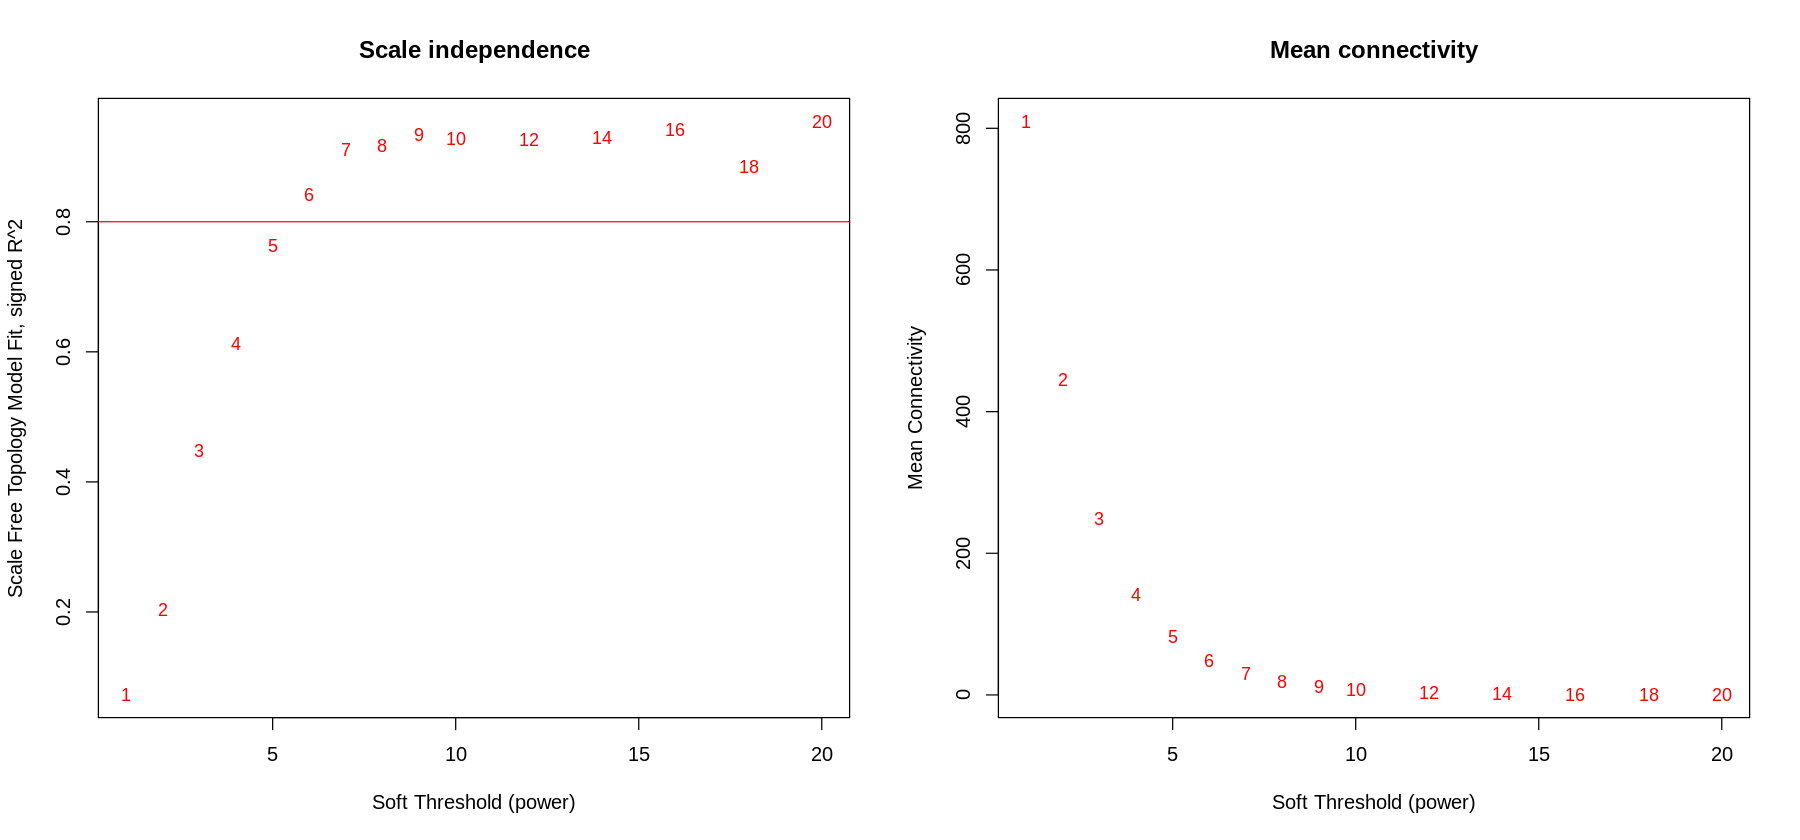

In [123]:
# Plot the results
#sizeGrWindow(9, 5)
options(repr.plot.width= 15, repr.plot.height = 7)
par(mfrow = c(1,2));
cex1 = 0.9;

# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit, signed R^2",
     type="n", main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")

# Red line corresponds to using an R^2 cut-off
abline(h=0.80,col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], 
     labels=powers, cex=cex1,
     col="red")

In [124]:
softPower = 8;
#calclute the adjacency matrix
adj = adjacency(datExpr,
                type = "signed", 
                power = softPower);
# turn adjacency matrix into a topological overlap matrix (TOM)
# to minimize the effects of noise and spurious associations
TOM = TOMsimilarityFromExpr(datExpr,
                            networkType = "signed",
                            TOMType = "signed",
                            power = softPower)

TOM calculation: adjacency..
..will use 3 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [125]:
saveRDS(TOM, file="files/4_wgcna/TOM_1496.rds")

In [81]:
colnames(TOM) =rownames(TOM) =SubGeneNames
dissTOM=1-TOM

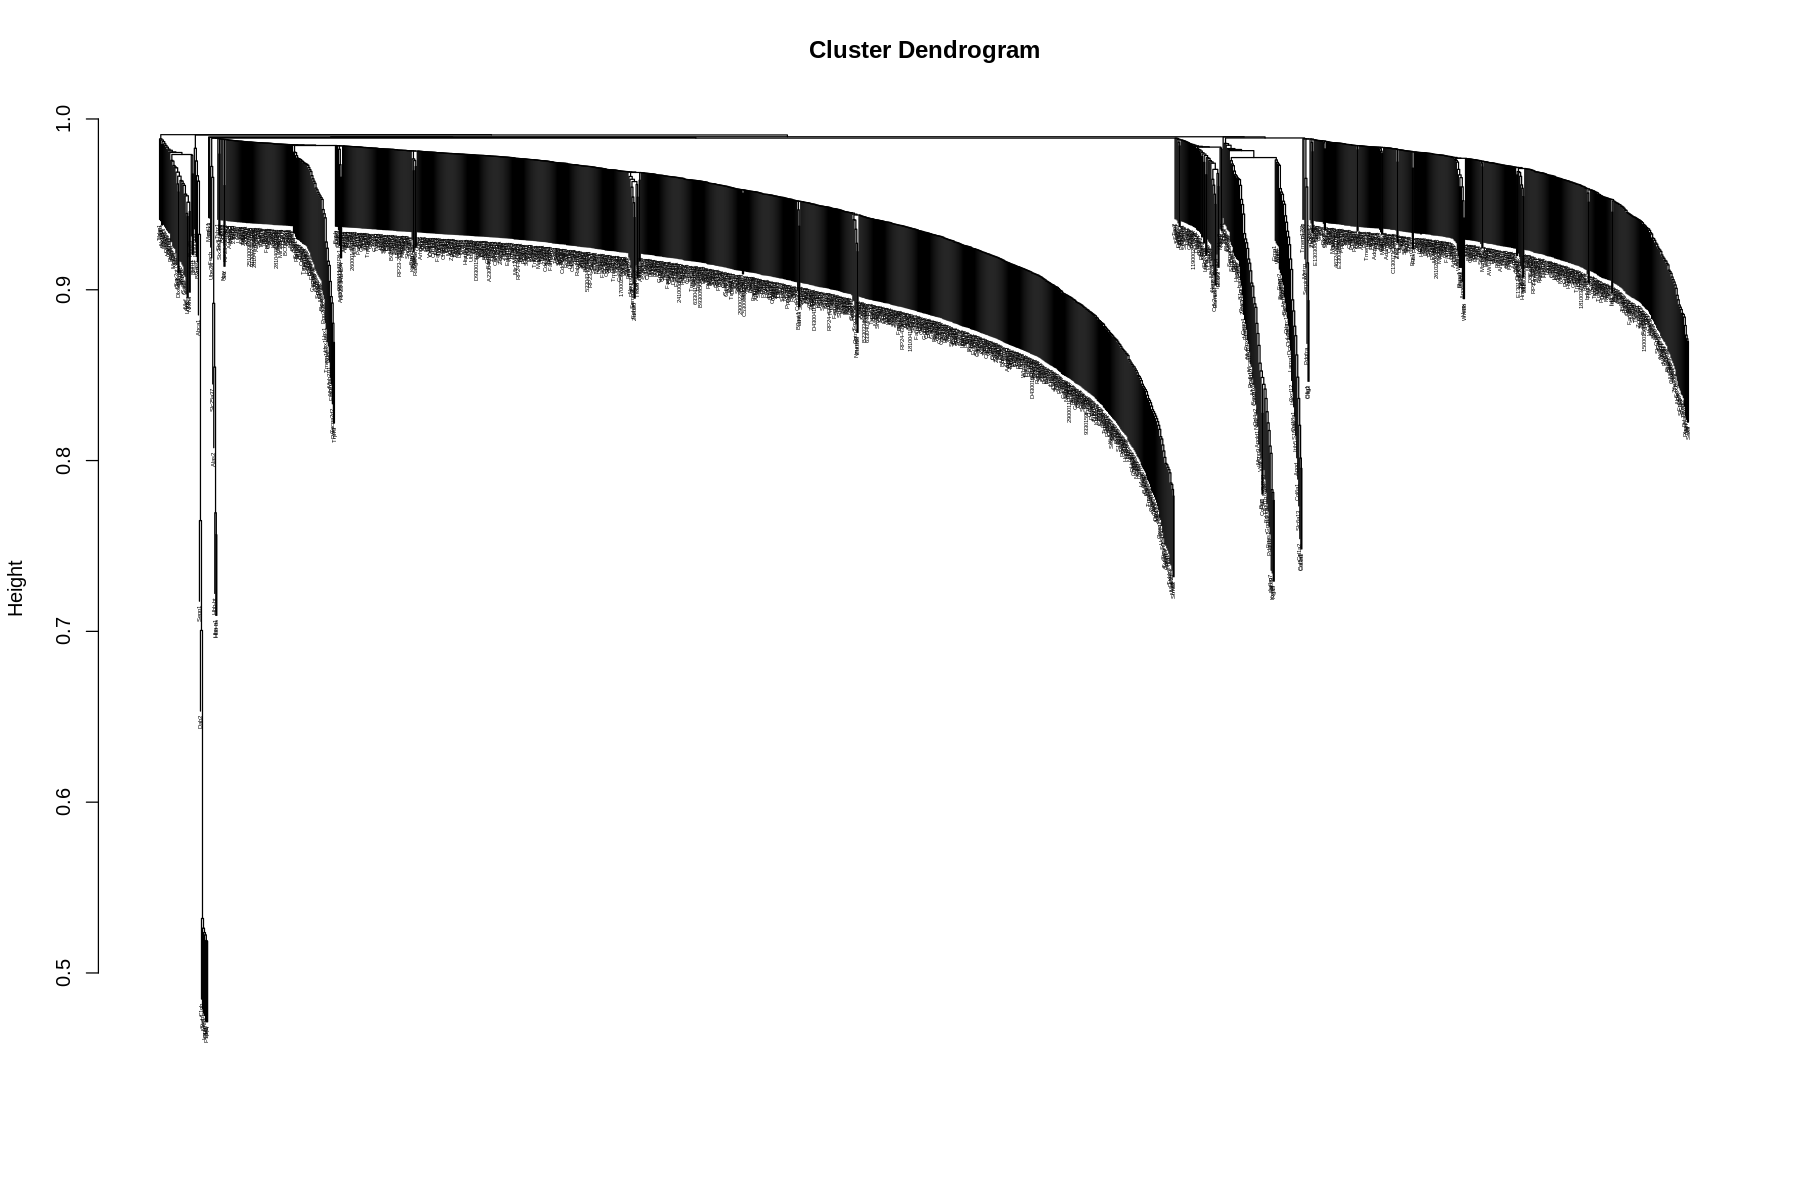

In [87]:
#hierarchical clustering of the genes based on the TOM dissimilarity measure
options(repr.plot.width= 15, repr.plot.height = 10)
geneTree = flashClust(as.dist(dissTOM),
                      method="average");

#plot the resulting clustering tree (dendrogram)
plot(geneTree, xlab="", sub="",cex=0.3);

In [88]:
# Set the minimum module size
minModuleSize = 20;

# Module identification using dynamic tree cut

dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
#dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, method="hybrid", deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize);

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)

dynamicMods
  0   1   2   3   4   5   6   7   8 
351 736 161  58  53  44  41  27  25 

In [89]:
#Plot the module assignment under the dendrogram; note: The grey color is reserved for unassigned genes
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

dynamicColors
    black      blue     brown     green      grey      pink       red turquoise 
       27       161        58        44       351        25        41       736 
   yellow 
       53 

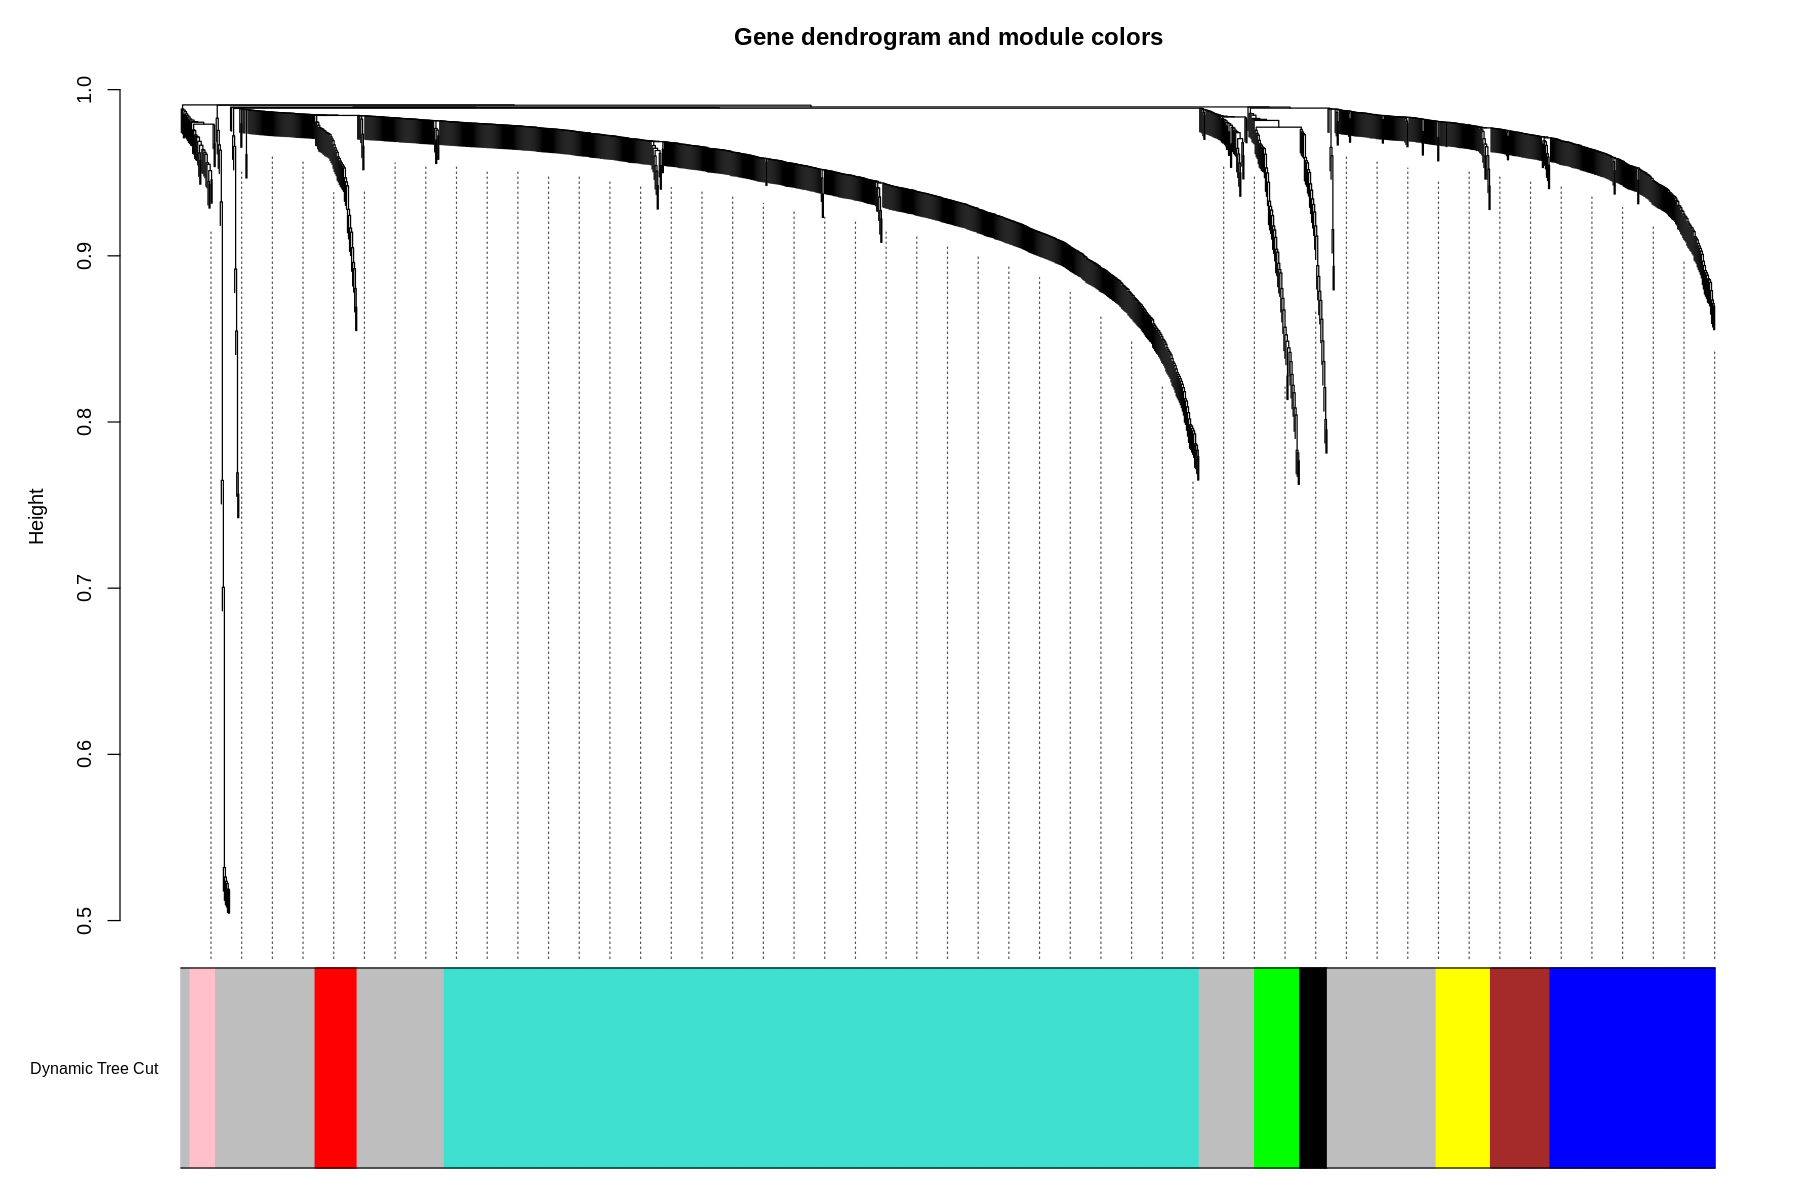

In [90]:
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, 
                    addGuide = TRUE, guideHang = 0.05, 
                    main = "Gene dendrogram and module colors")

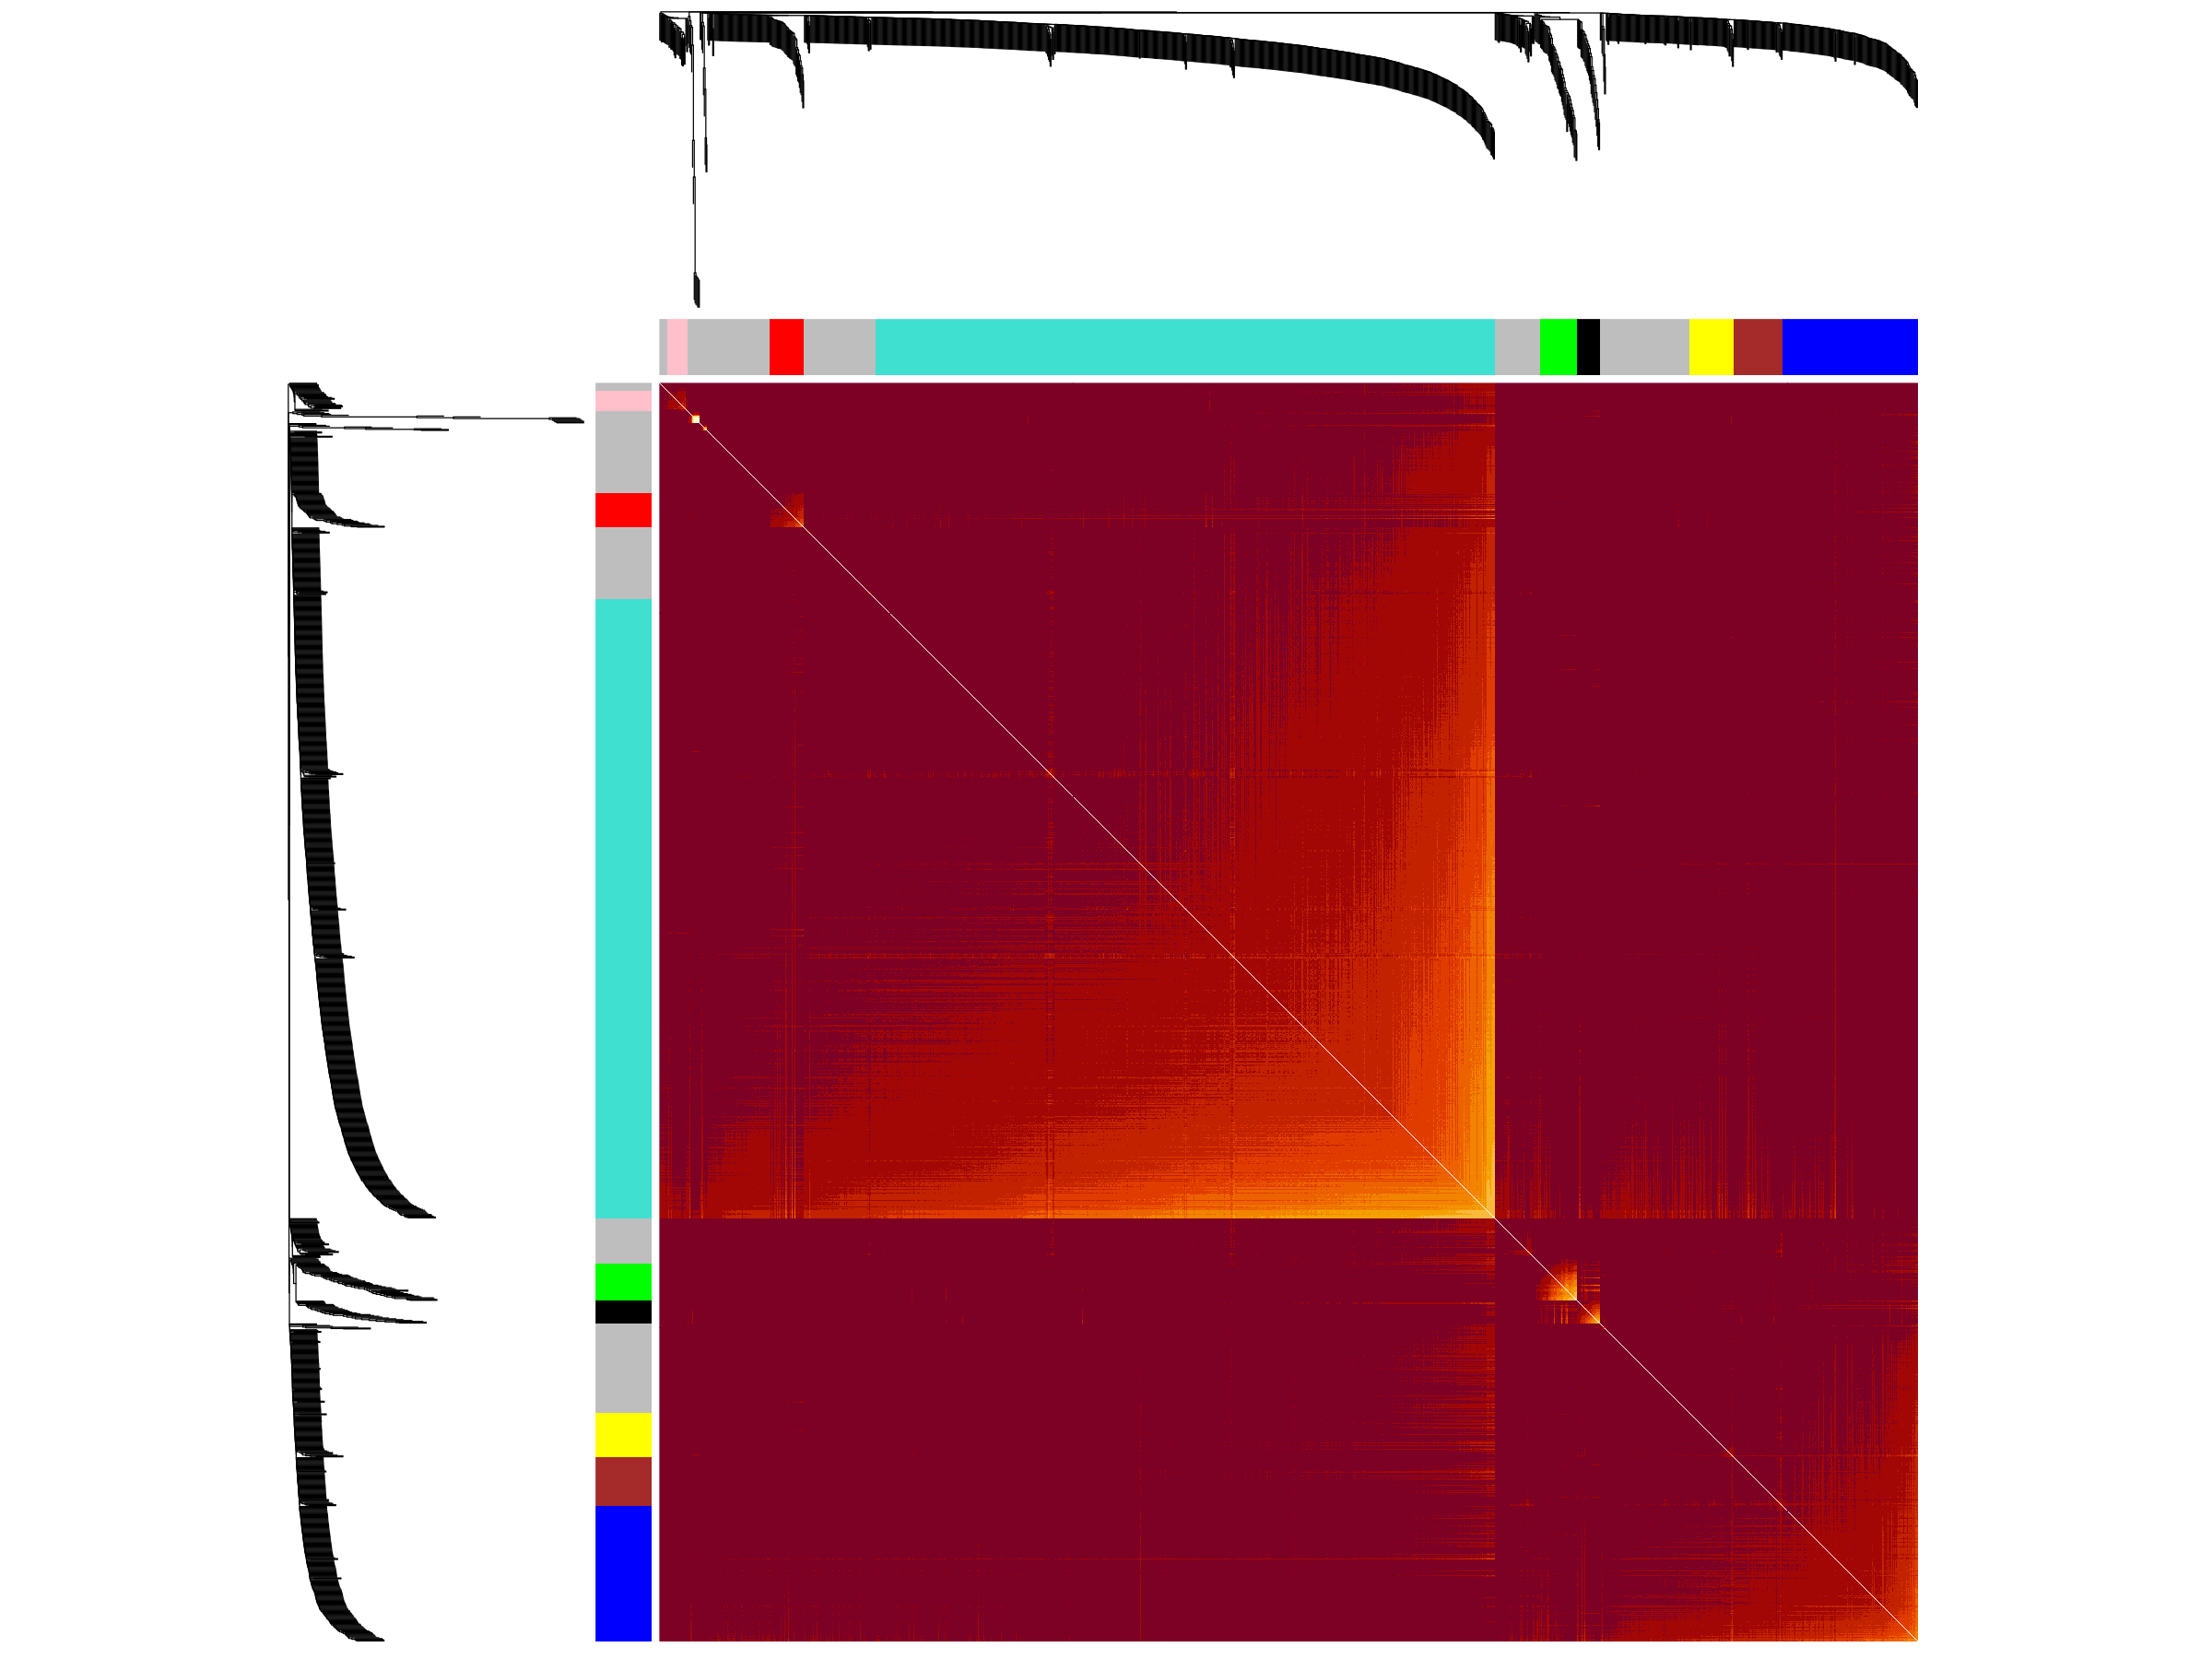

In [93]:
#set the diagonal of the dissimilarity to NA 
options(repr.plot.width= 20, repr.plot.height = 15)
diag(dissTOM) = NA;
#Visualize the Tom plot. Raise the dissimilarity matrix to a power  to bring out the module structure
#sizeGrWindow(7,7)
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

In [99]:
module_colors= setdiff(unique(dynamicColors), "grey")
dir.create("files/4_wgcna/genes_1496", showWarnings = F, recursive = T)
for (color in module_colors){
    module=SubGeneNames[which(dynamicColors==color)]
    write.table(module, paste("files/4_wgcna/genes_1496/module_",color, ".txt",sep=""), sep="\t",
                row.names=FALSE, col.names=FALSE,quote=FALSE)   
}

The list of gene names can be found at `files/4_wgcna` 

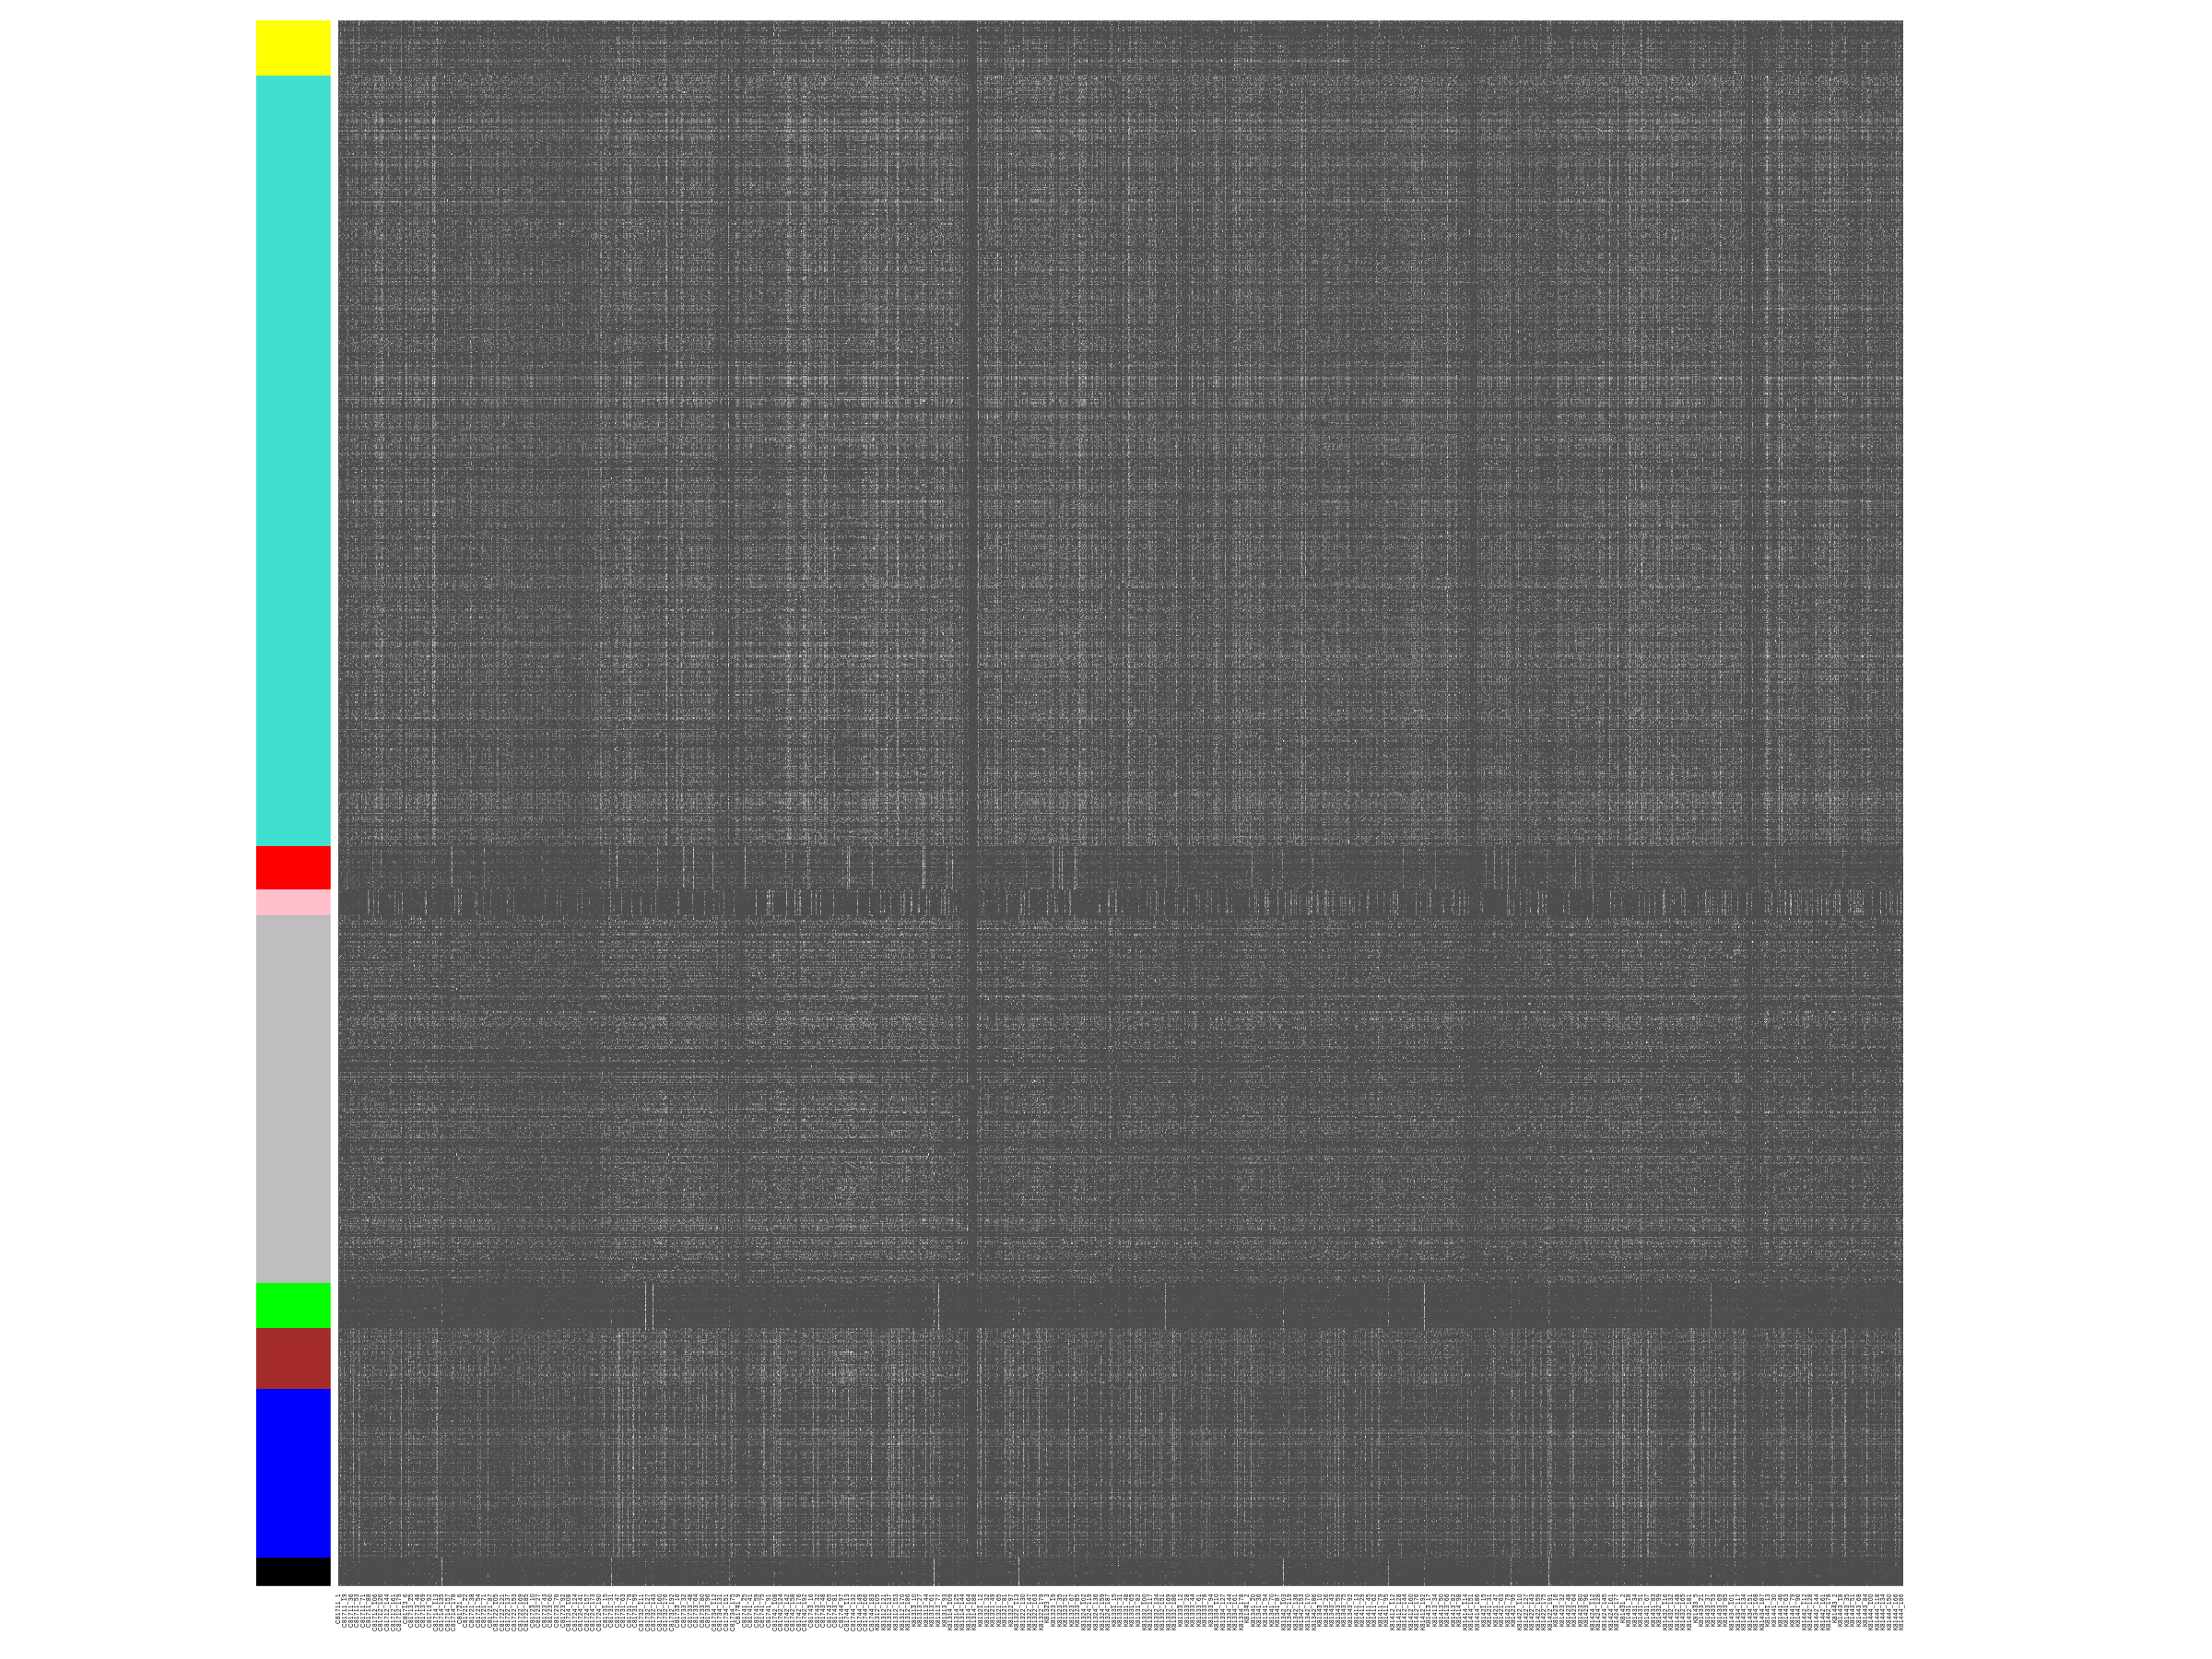

In [95]:
module.order <- unlist(tapply(1:ncol(datExpr),as.factor(dynamicColors),I))
m<-t(t(datExpr[,module.order])/apply(datExpr[,module.order],2,max))
heatmap(t(m),zlim=c(0,1),col=gray.colors(100),
        Rowv=NA,Colv=NA,labRow=NA, scale="none",
        RowSideColors=dynamicColors[module.order])

## Using 7477 Filtered Genes

In [107]:
SubGeneNames = sort(sc@genes)
n = length(SubGeneNames)
datExpr = mydata.trans[,SubGeneNames]
dim(datExpr)

[1] 4135 7477

In [108]:
powers = c(c(1:10), seq(from = 12, to=20, by=2));
sft = pickSoftThreshold(datExpr, 
                        dataIsExpr = TRUE,
                        powerVector = powers,
                        corFnc = cor,
                        corOptions = list(use = 'p'),
                        networkType = "signed")

   Power SFT.R.sq    slope truncated.R.sq  mean.k. median.k. max.k.
1      1 1.16e-07  0.00593          0.993 4130.000  4120.000 4780.0
2      2 2.92e-02 -1.51000          0.986 2300.000  2280.000 3100.0
3      3 1.08e-01 -1.96000          0.971 1290.000  1260.000 2040.0
4      4 2.49e-01 -2.28000          0.952  725.000   704.000 1350.0
5      5 4.64e-01 -2.60000          0.954  413.000   393.000  912.0
6      6 6.47e-01 -2.83000          0.962  237.000   221.000  630.0
7      7 7.48e-01 -2.90000          0.969  137.000   124.000  446.0
8      8 8.29e-01 -2.94000          0.978   80.500    70.200  321.0
9      9 8.79e-01 -3.04000          0.979   47.700    39.800  235.0
10    10 9.07e-01 -3.03000          0.982   28.600    22.800  175.0
11    12 9.23e-01 -2.84000          0.982   10.700     7.570  101.0
12    14 9.37e-01 -2.55000          0.987    4.320     2.560   62.3
13    16 9.38e-01 -2.28000          0.987    1.880     0.885   40.2
14    18 9.26e-01 -2.03000          0.968    0.8

That took 6 minutes. Notice that the SFT.R.Sq is smaller by a factor of 10.

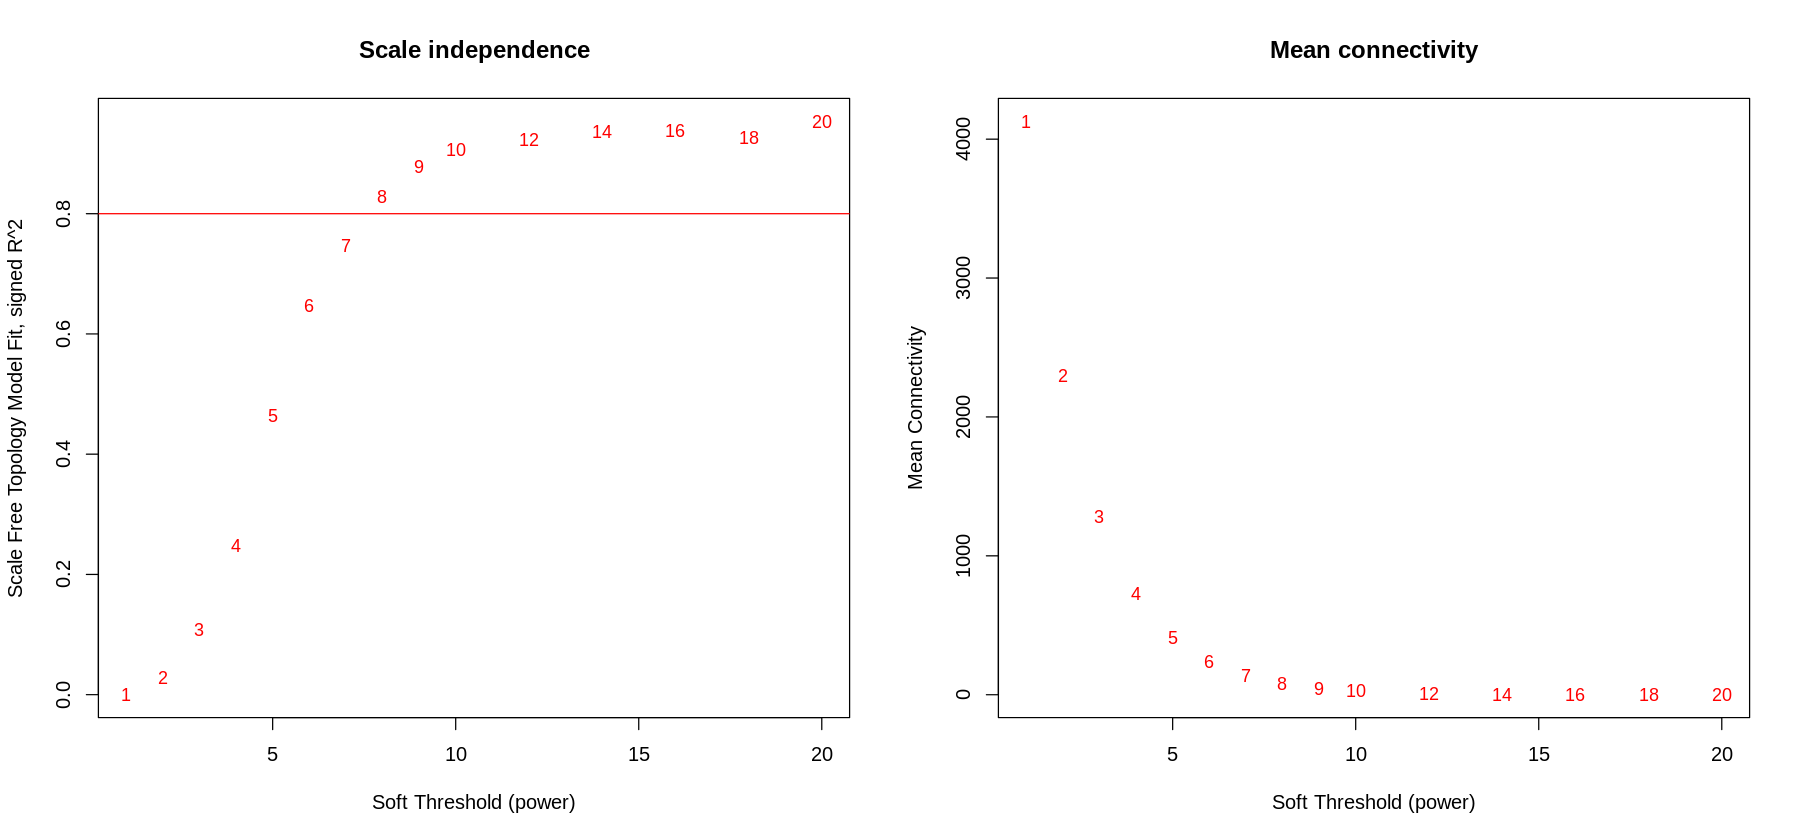

In [109]:
options(repr.plot.width= 15, repr.plot.height = 7)
par(mfrow = c(1,2));
cex1 = 0.9;
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit, signed R^2",
     type="n", main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.80,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], 
     labels=powers, cex=cex1,
     col="red")

This looks like a slightly higher resolution version of the 1496 genes.

In [ ]:
softPower = 8;
adj = adjacency(datExpr,
                type = "signed", 
                power = softPower);
TOM = TOMsimilarityFromExpr(datExpr,
                            networkType = "signed",
                            TOMType = "signed",
                            power = softPower)

This ran for 22 minutes, at 5.7GB

In [112]:
colnames(TOM) =rownames(TOM) =SubGeneNames
dissTOM=1-TOM

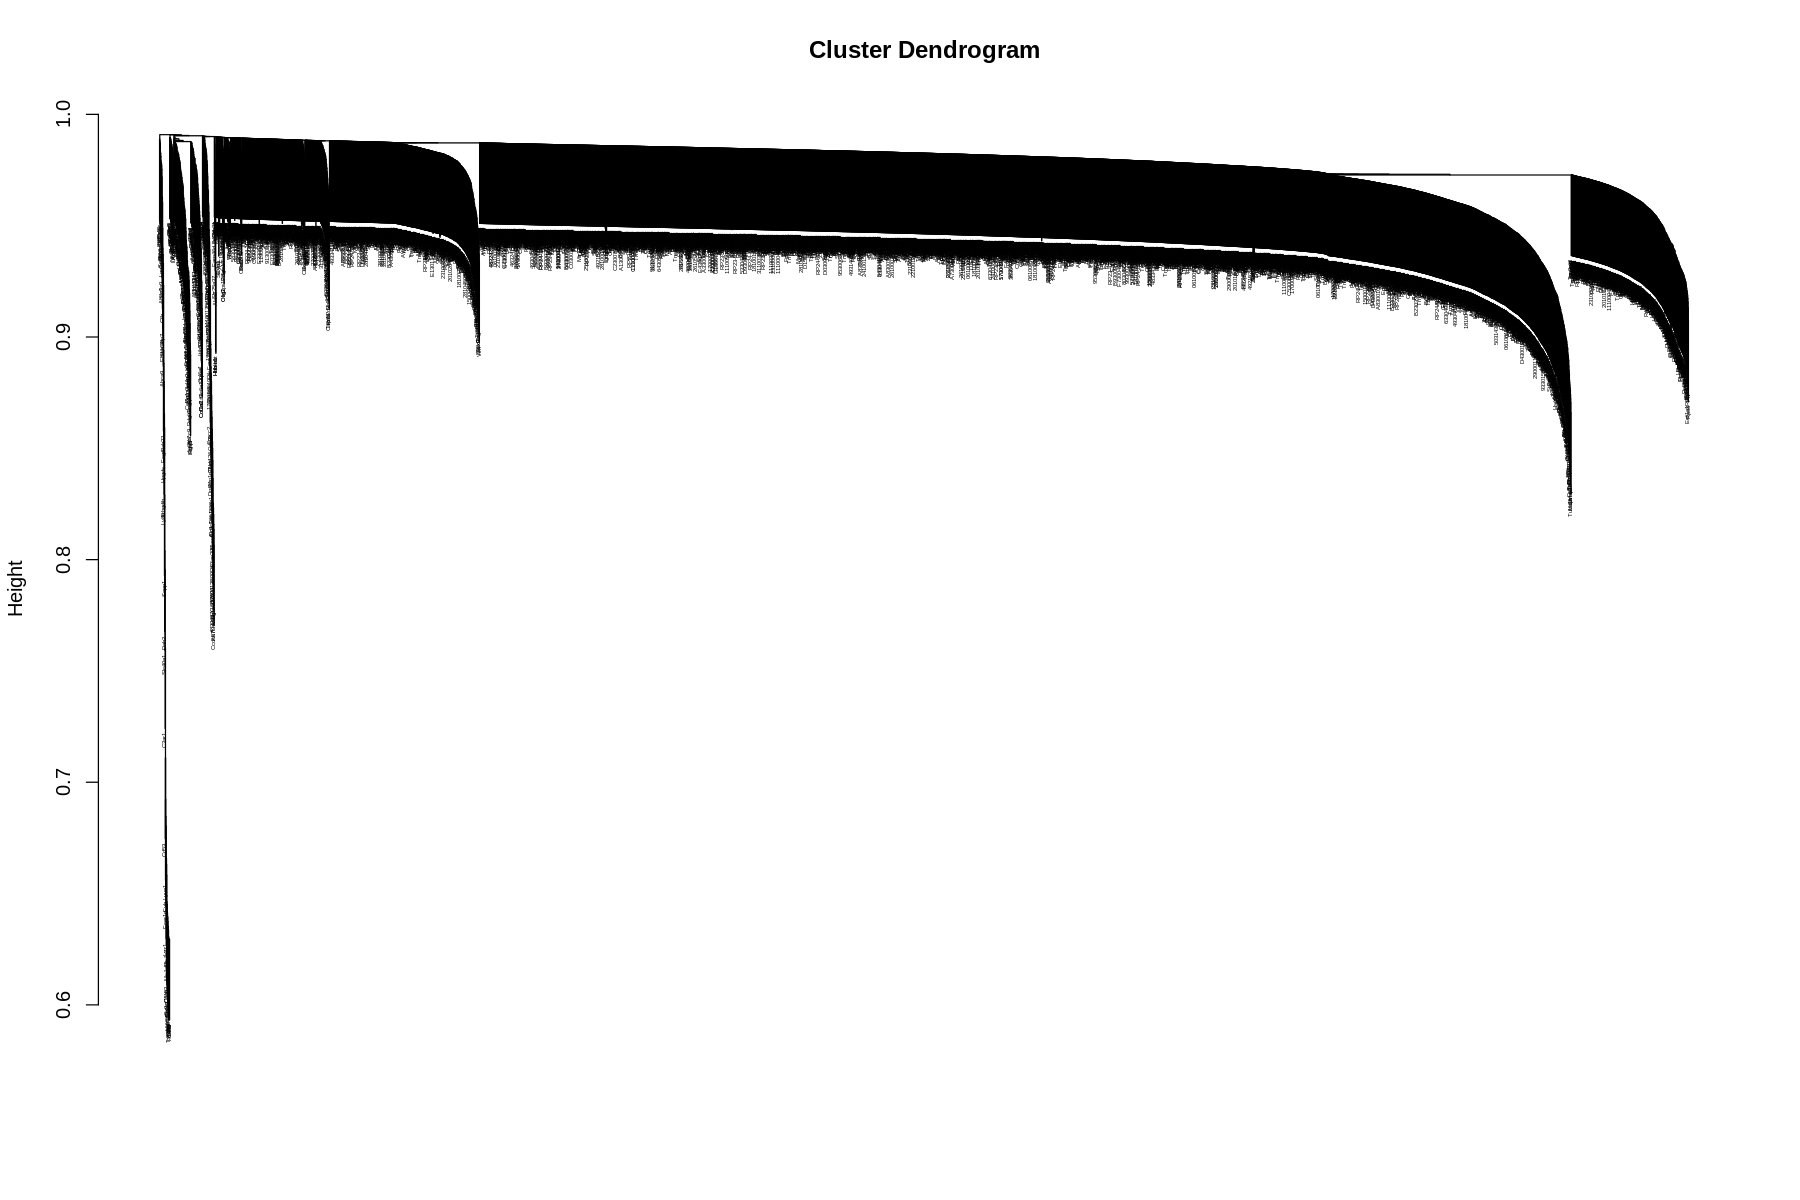

In [113]:
#hierarchical clustering of the genes based on the TOM dissimilarity measure
options(repr.plot.width= 15, repr.plot.height = 10)
geneTree = flashClust(as.dist(dissTOM),
                      method="average");
#plot the resulting clustering tree (dendrogram)
plot(geneTree, xlab="", sub="",cex=0.3);

In [114]:
minModuleSize = 20;
dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
table(dynamicMods)

dynamicMods
   0    1    2    3    4    5    6    7 
3947 2622  574  149   60   44   43   38 

In [115]:
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

dynamicColors
    black      blue     brown     green      grey       red turquoise    yellow 
       38       574       149        44      3947        43      2622        60 

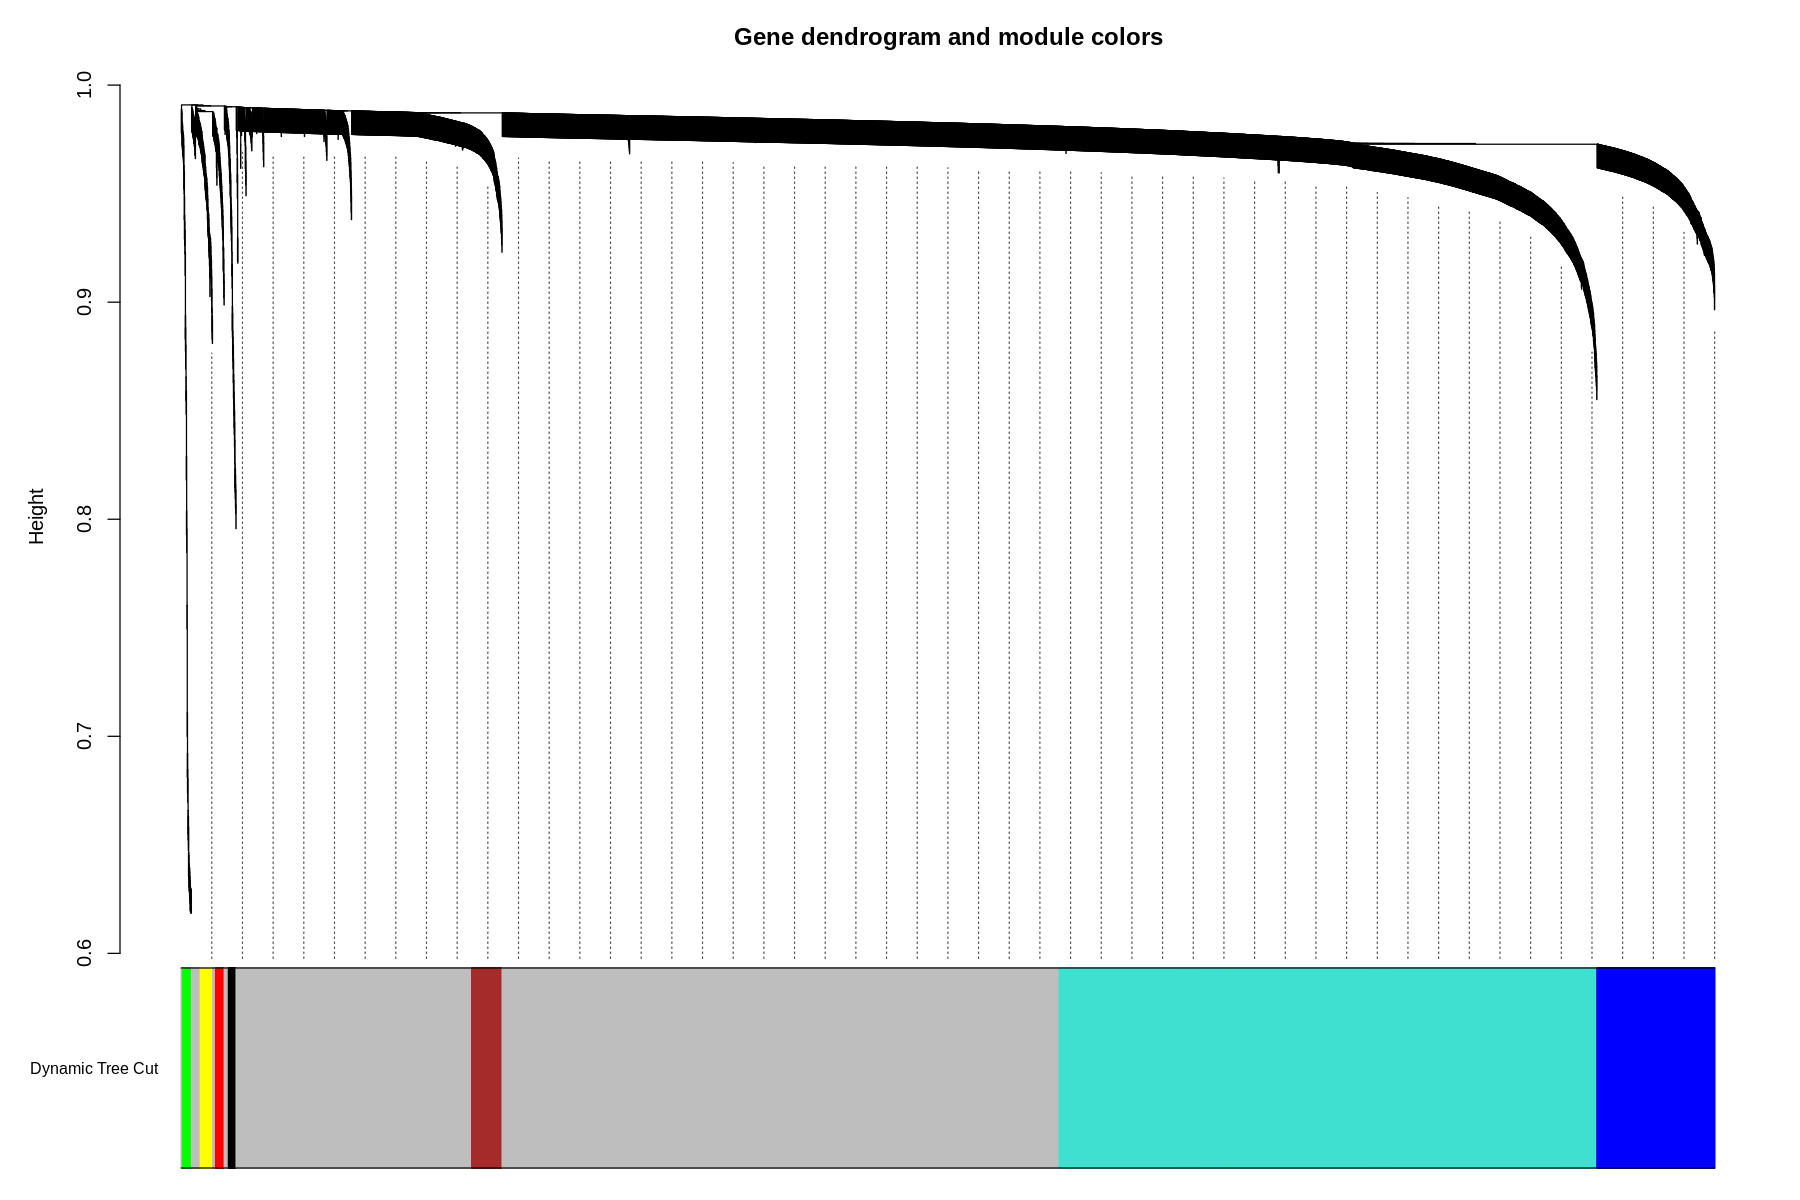

In [116]:
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, 
                    addGuide = TRUE, guideHang = 0.05, 
                    main = "Gene dendrogram and module colors")

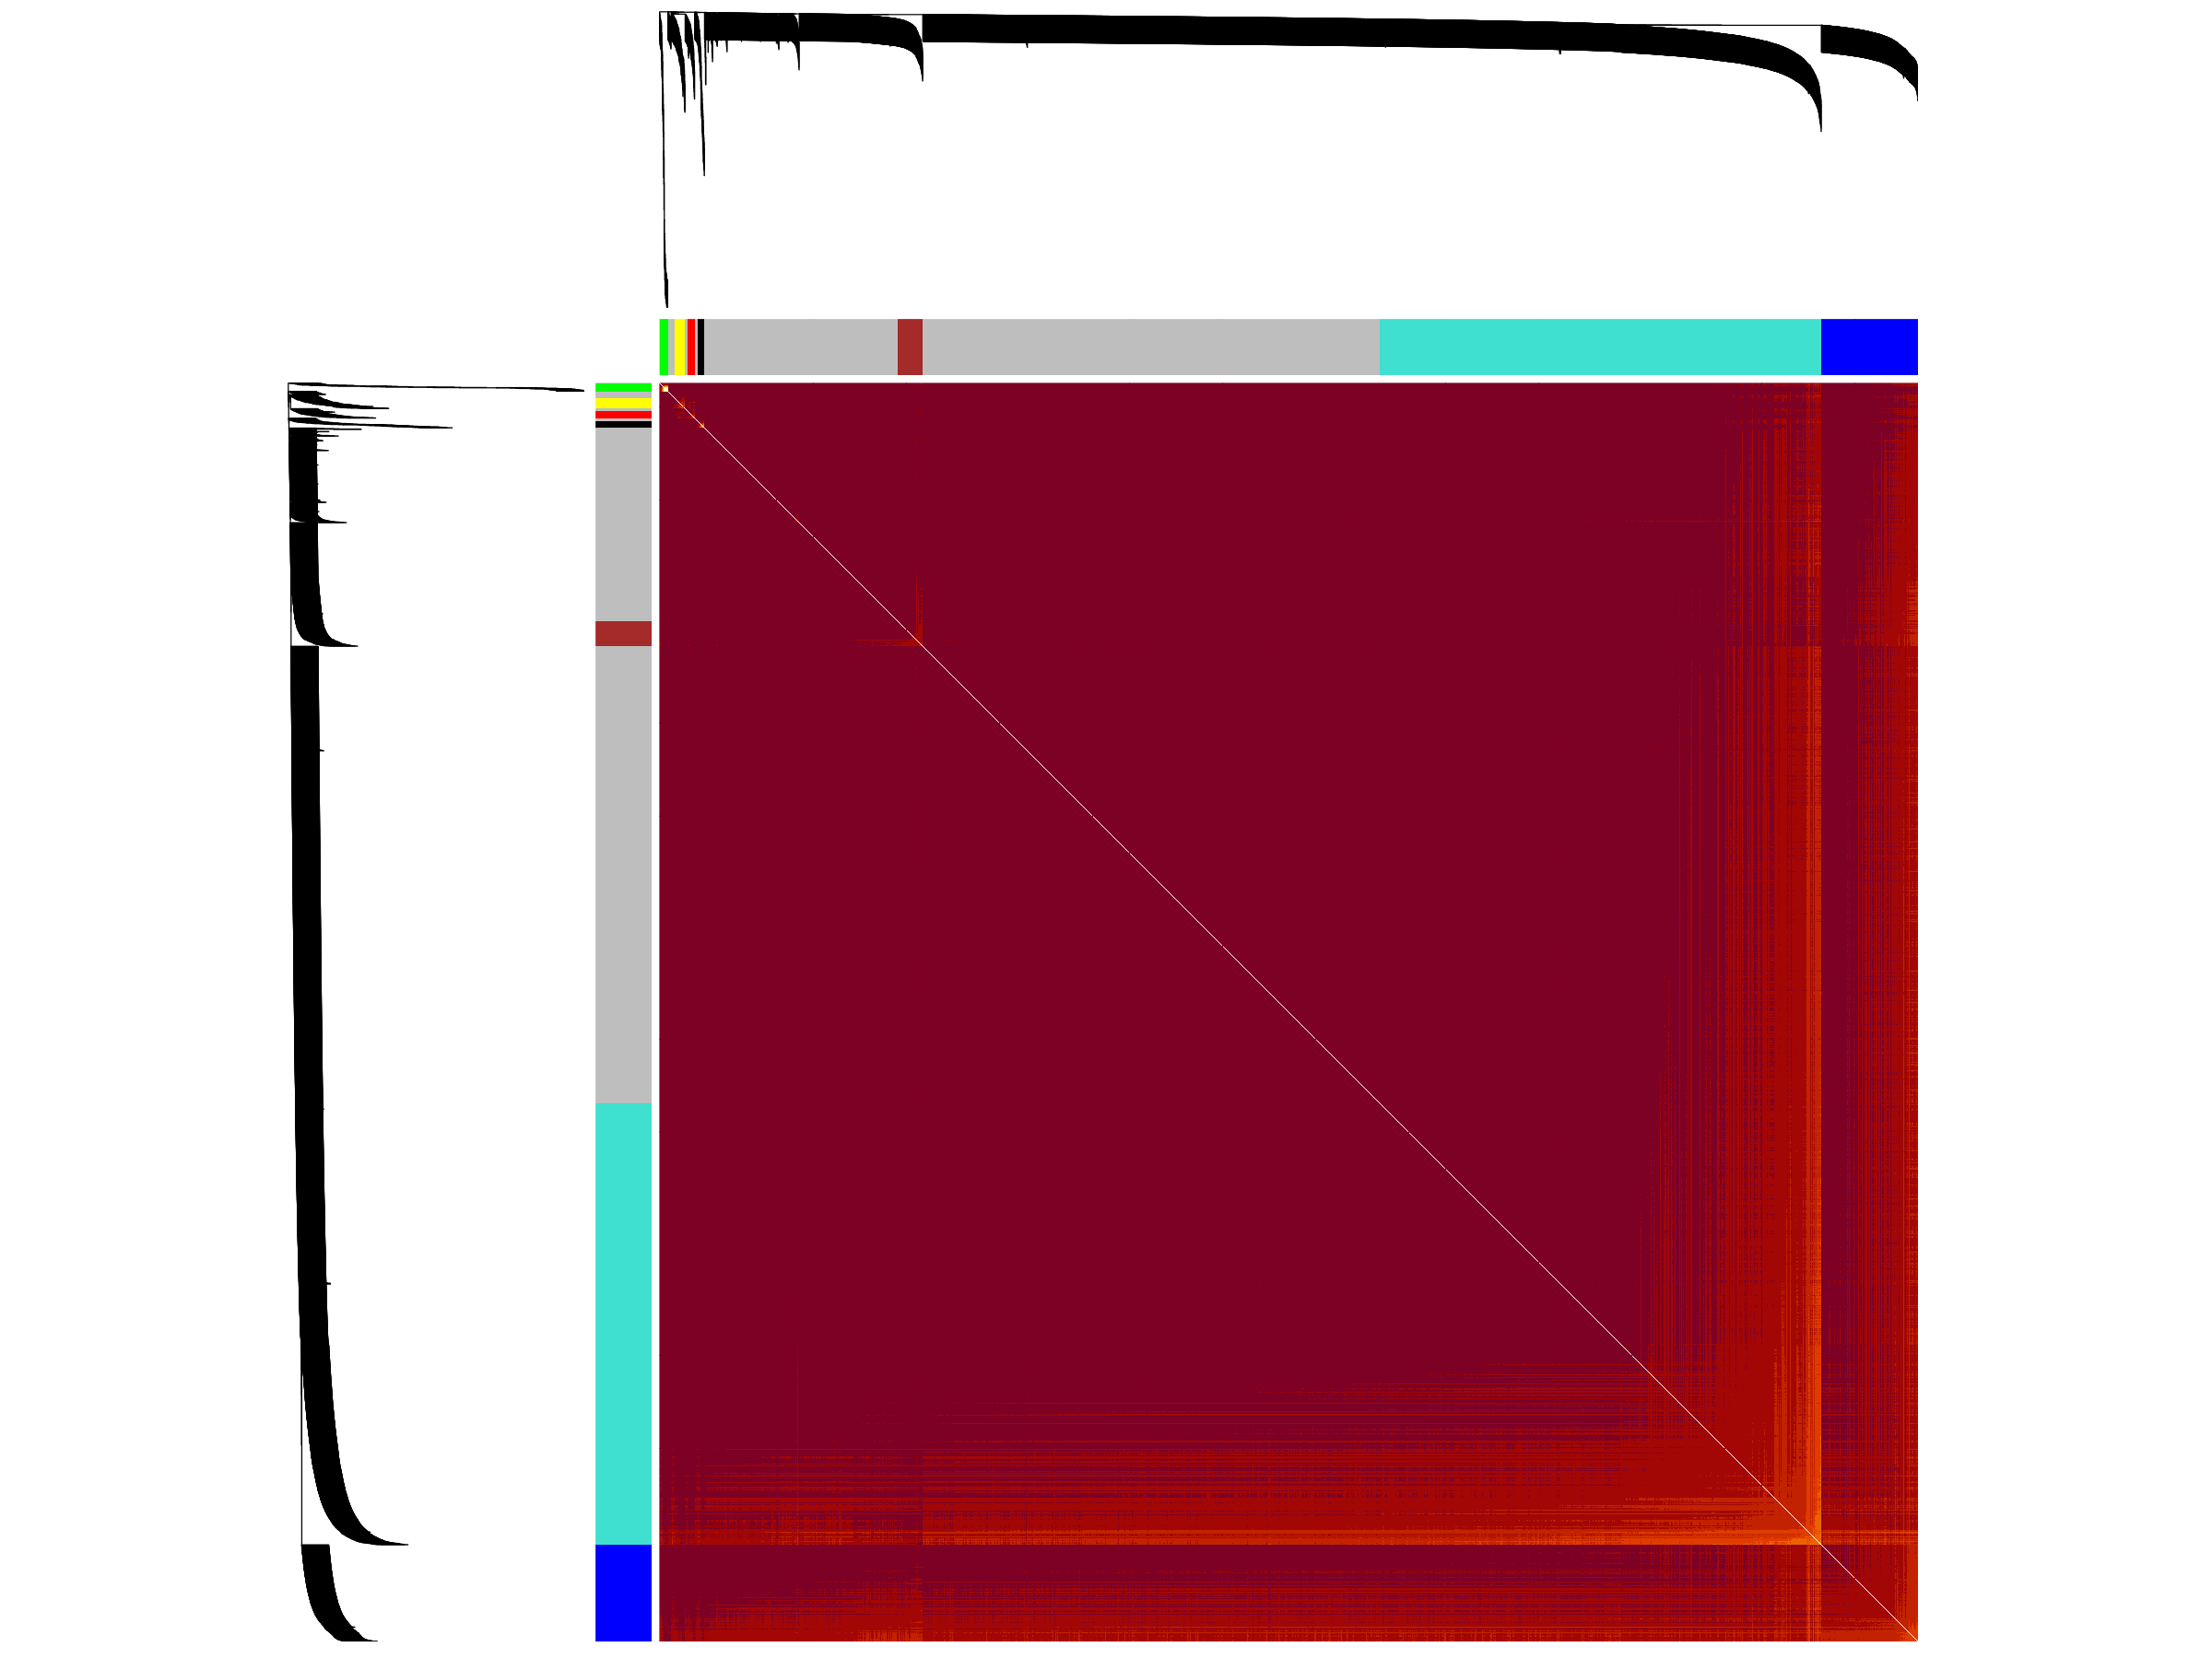

In [117]:
options(repr.plot.width= 20, repr.plot.height = 15)
diag(dissTOM) = NA;
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

The heat map in the previous analysis was better in my opinion. Hard to see differential expression.

In [118]:
module_colors= setdiff(unique(dynamicColors), "grey")
dir.create("files/4_wgcna/genes_7477", showWarnings = F, recursive = T)
for (color in module_colors){
    module=SubGeneNames[which(dynamicColors==color)]
    write.table(module, paste("files/4_wgcna/genes_7477/module_",color, ".txt",sep=""), sep="\t",
                row.names=FALSE, col.names=FALSE,quote=FALSE)   
}

The list of gene names can be found at `files/4_wgcna/genes_7477`

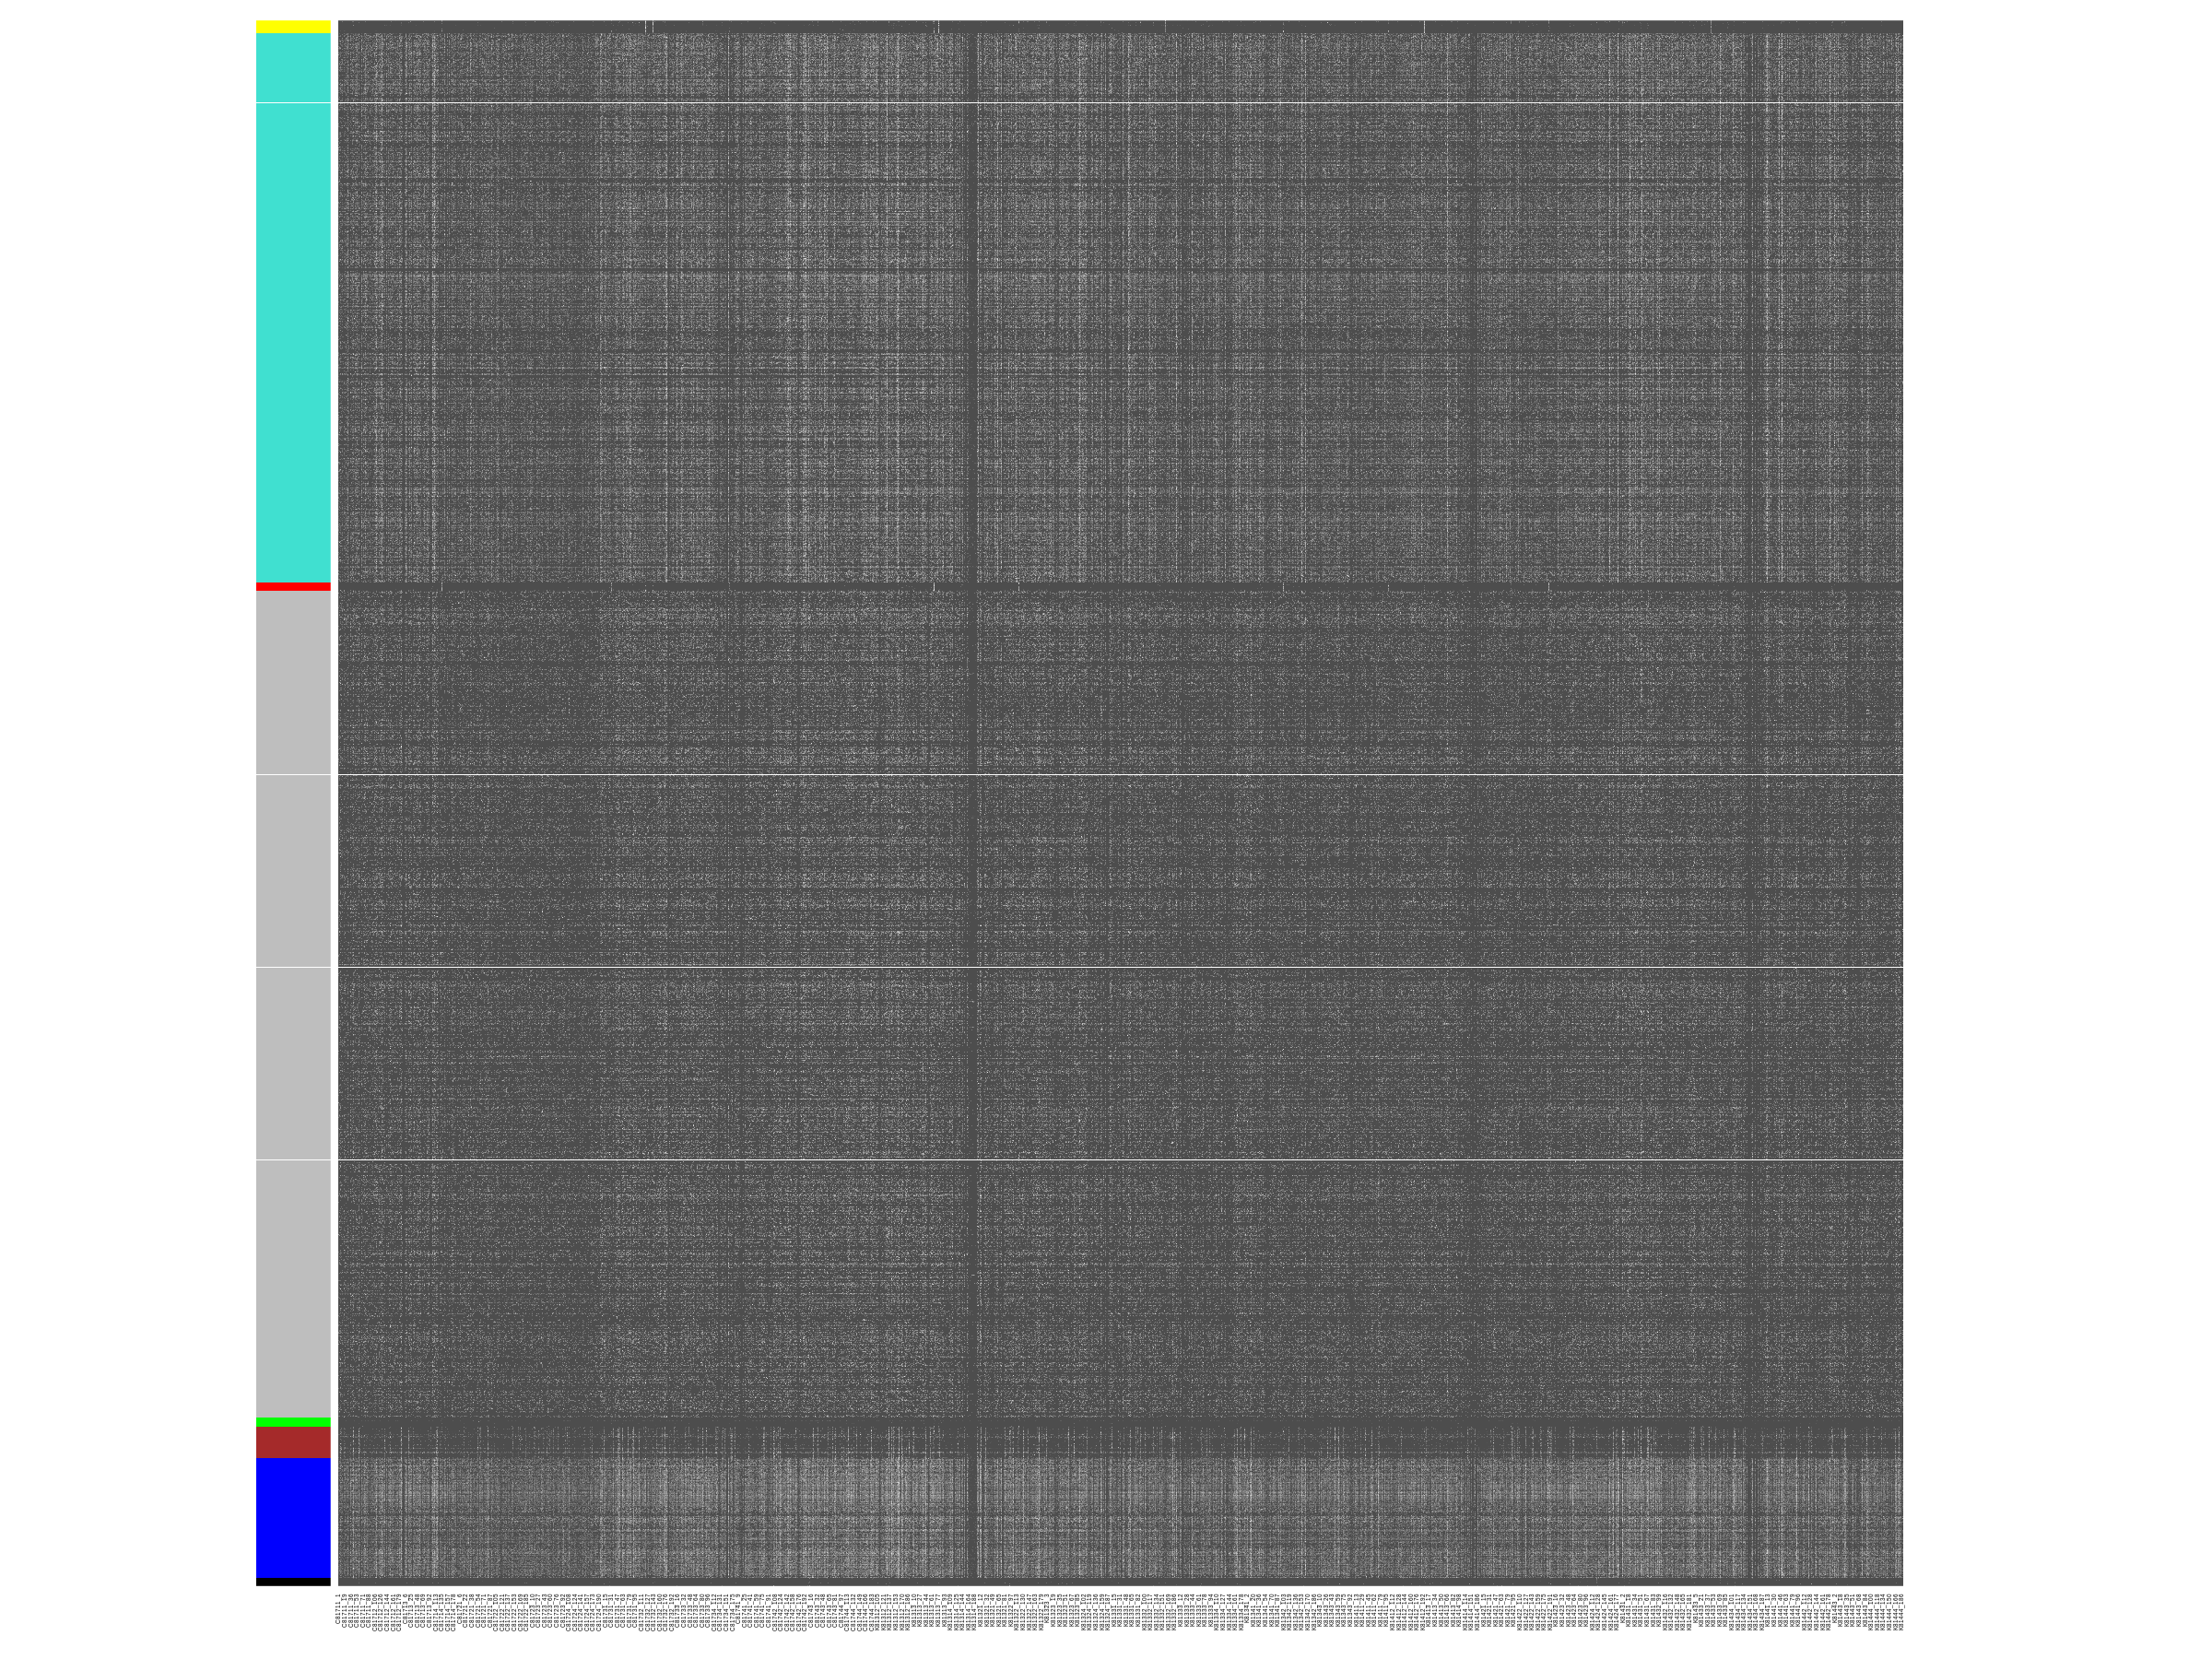

In [119]:
module.order <- unlist(tapply(1:ncol(datExpr),as.factor(dynamicColors),I))
m<-t(t(datExpr[,module.order])/apply(datExpr[,module.order],2,max))
heatmap(t(m),zlim=c(0,1),col=gray.colors(100),
        Rowv=NA,Colv=NA,labRow=NA, scale="none",
        RowSideColors=dynamicColors[module.order])

In [120]:
saveRDS(TOM, file="files/4_wgcna/TOM_7477.rds")

## Using 18816 Filtered Genes

(processed on ubiquitous server)

In [2]:
library(WGCNA)
library(flashClust)
TOM <- readRDS("files/4_wgcna//TOM_18816.rds")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor



Attaching package: ‘flashClust’


The following object is masked from ‘package:fastcluster’:

    hclust


The following object is masked from ‘package:stats’:

    hclust




In [3]:
##colnames(TOM) = rownames(TOM) = SubGeneNames
dissTOM = 1-TOM

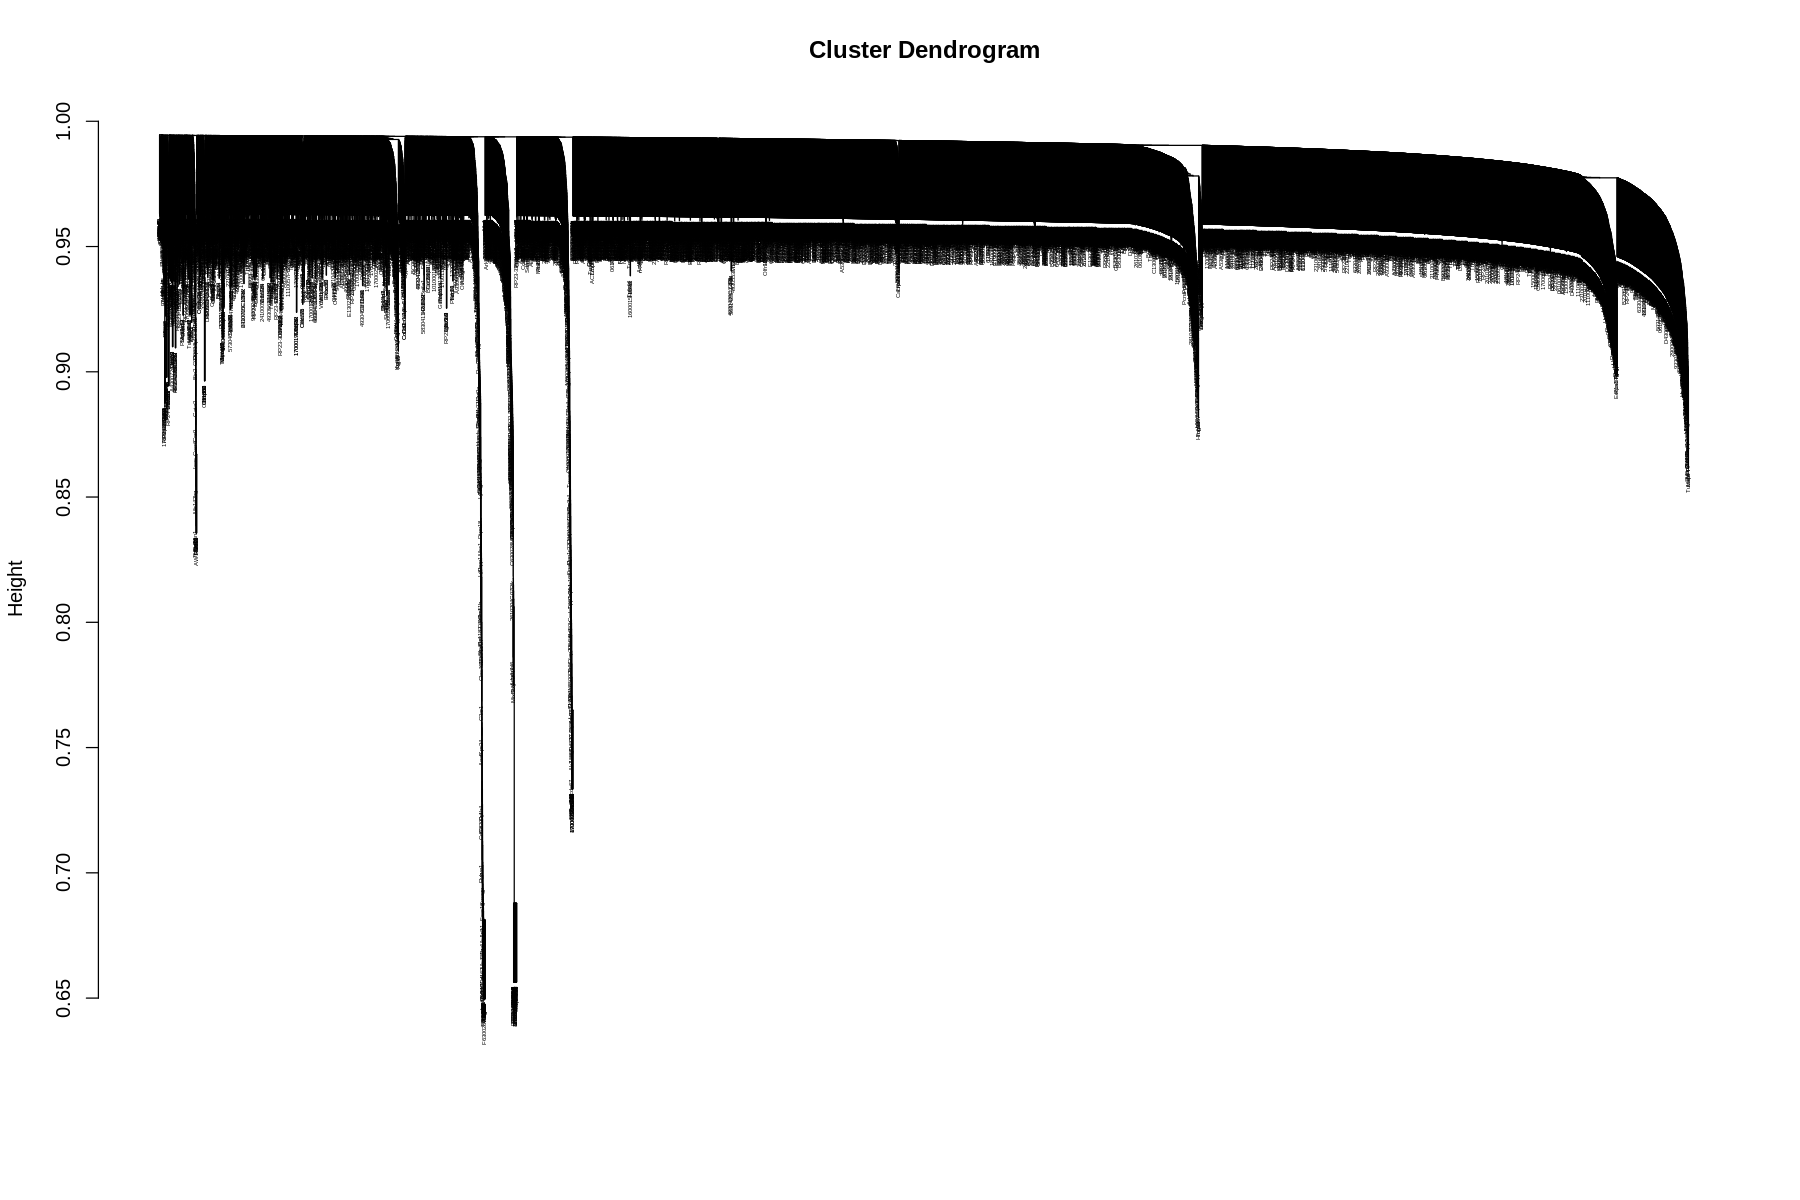

In [4]:
options(repr.plot.width= 15, repr.plot.height = 10); 
geneTree = flashClust(as.dist(dissTOM), method="average")
plot(geneTree, xlab="", sub="",cex=0.3);

In [21]:
minModuleSize = 20;
dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
table(dynamicMods)

ERROR: Error in cutree(dendro, h = heightcutoff): the 'height' component of 'tree' is not sorted (increasingly)


How many genes are not in the correct sorting order?

In [5]:
#clusts$height <- round(clusts$height, 6) 
sum(sort(geneTree$height) != geneTree$height)

[1] 22

In [6]:
geneTree$height[sort(geneTree$height) != geneTree$height]

[1] 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044
 [8] 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6878092 0.6878092
[15] 0.8670505 0.8670505 0.9292540 0.9292540 0.9551502 0.9551502 0.9571401
[22] 0.9571401

22 genes not sorted. If we round these specific genes to 14 decimal places it should look like a rising list

In [7]:
round(geneTree$height[sort(geneTree$height) != geneTree$height], 14)

[1] 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044
 [8] 0.6811044 0.6811044 0.6811044 0.6811044 0.6811044 0.6878092 0.6878092
[15] 0.8670505 0.8670505 0.9292540 0.9292540 0.9551502 0.9551502 0.9571401
[22] 0.9571401

In [8]:
geneTree$height <- round(geneTree$height, 14)

In [9]:
geneTree$height[sort(geneTree$height) != geneTree$height]
# no output, so this should be correct now

numeric(0)

In [10]:
minModuleSize = 20;
dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
table(dynamicMods)

dynamicMods
    0     1     2     3     4     5     6     7     8     9    10 
15453  1631   878   287   164   131   107    57    45    33    30 

In [11]:
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

dynamicColors
    black      blue     brown     green      grey   magenta      pink    purple 
       57       878       287       131     15453        33        45        30 
      red turquoise    yellow 
      107      1631       164 

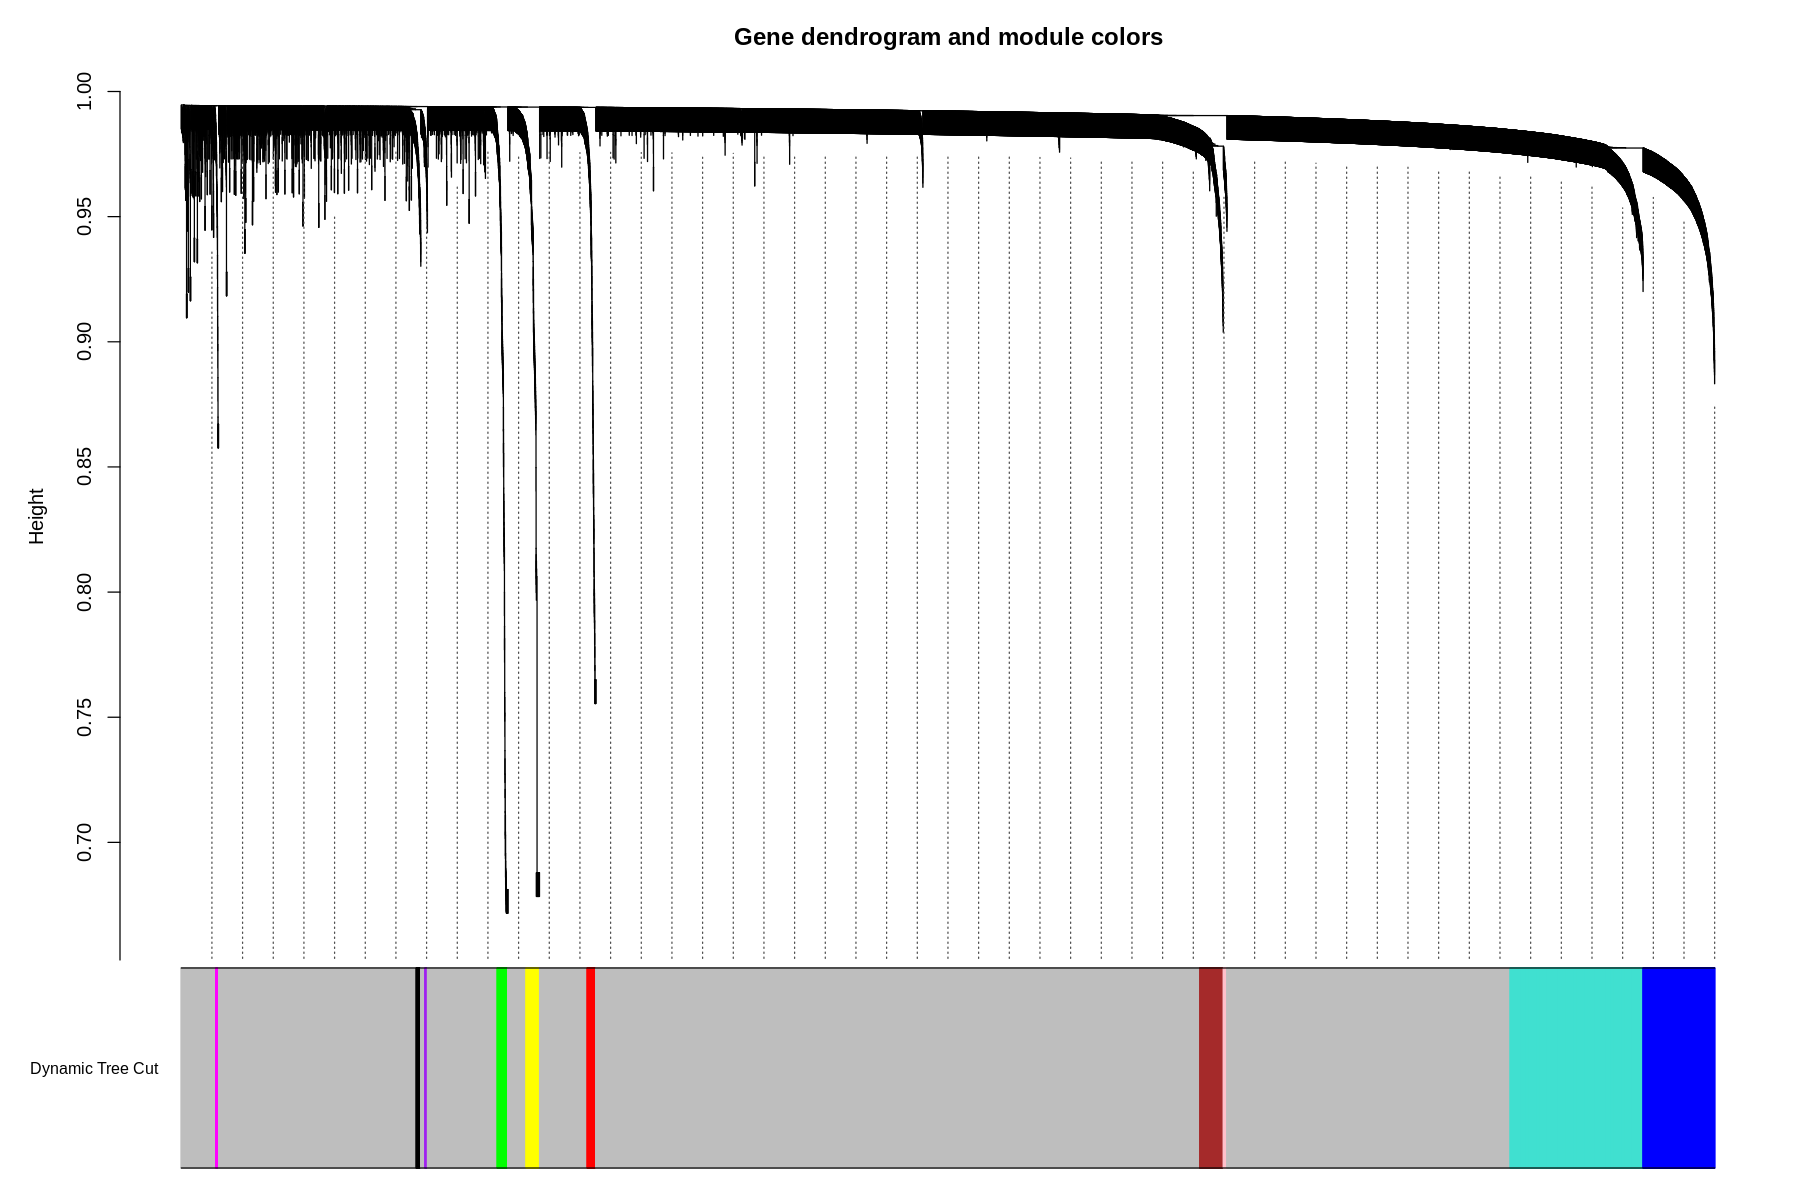

In [12]:
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, 
                    addGuide = TRUE, guideHang = 0.05, 
                    main = "Gene dendrogram and module colors")

In [38]:
#which(dynamicColors=="red")

In [17]:
module_colors= setdiff(unique(dynamicColors), "grey")
dir.create("files/4_wgcna/genes_18816", showWarnings = F, recursive = T)
for (color in module_colors){
    module=geneTree$labels[which(dynamicColors==color)]
    write.table(module, paste("files/4_wgcna/genes_18816/module_",color, ".txt",sep=""), sep="\t",
                row.names=FALSE, col.names=FALSE,quote=FALSE)   
}

In [28]:
sum(grepl("Dot1l", geneTree$labels))

[1] 1

In [39]:
#saveRDS(c(geneTree, dissTOM), file="genetree.disstom.18816.rds")

In [ ]:
options(repr.plot.width= 20, repr.plot.height = 15)
diag(dissTOM) = NA;
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

(keeps dying, but Dot1l does not appear to be in any of the above exported gene modules)

Dot1L does not appear in any of the above modules for neither the 1496, the 7477, or the 18816 analyses. 

We should now try to do WGCNA for individual clusters

# Cluster Level WGCNA

In [2]:
library(WGCNA)
library(RaceID)
library(flashClust)
options(stringsAsFactors = FALSE);
enableWGCNAThreads()

Allowing parallel execution with up to 3 working processes.


In [61]:
sc <- readRDS('~/Downloads/sc_object_RaceID.RDS')
mydata.trans=t(as.matrix(mydata))

In [88]:
res <- sapply(unique(sort(sc@cpart)), 
           function(x) c(paste("c", x, sep=""), nrow(mydata.trans[sc@cpart==x,])))
t(res)

"c1 , 300","c2 , 438","c3 , 175","c4 , 547","c5 , 261","c6 , 405","c7, 73","c8 , 209","c9 , 284","c10, 105",⋯,"c18, 45","c19, 6","c20, 10","c21, 10",c22,"c23, 67","c24, 2","c25, 36",c26,c27


## Analysis at the cluster level

So one thing that is not clear to me is which set of genes we will actually use. 

* Do we use the same set of genes across all clusters? 
* Or do we pick the top N DE genes for each cluster?

Given that Dot1l did not appear in the HVG list, but did appear in the 7477 list, we already have a common gene list. However, in the 7477 analysis, Dot1l was not in any good gene modules.


Maybe that will change at the individual cluster level.

### Same Set of Genes 7477



In [63]:
SubGeneNames = sort(sc@genes)
n = length(SubGeneNames)
datExpr = mydata.trans[,SubGeneNames]
dim(datExpr)

[1] 4135 7477

   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0349  1.940         0.8140 4130.000  4140.000 4840.0
2      2   0.1460  3.930         0.6250 2330.000  2330.000 3200.0
3      3   0.2220  3.920         0.1790 1330.000  1320.000 2160.0
4      4   0.1800  2.710        -0.0537  768.000   750.000 1480.0
5      5   0.0264  0.336         0.4210  449.000   430.000 1030.0
6      6   0.0156 -0.248         0.9350  266.000   248.000  736.0
7      7   0.1340 -0.758         0.9920  160.000   144.000  535.0
8      8   0.5180 -1.850         0.9650   97.000    84.400  395.0
9      9   0.7320 -2.350         0.9740   59.800    49.900  296.0
10    10   0.8470 -2.580         0.9890   37.400    29.700  226.0
11    12   0.8910 -2.720         0.9870   15.400    10.800  136.0
12    14   0.9130 -2.570         0.9910    6.750     4.040   86.1
13    16   0.9060 -2.370         0.9840    3.200     1.550   56.9
14    18   0.8950 -2.090         0.9450    1.650     0.613   39.0
15    20  

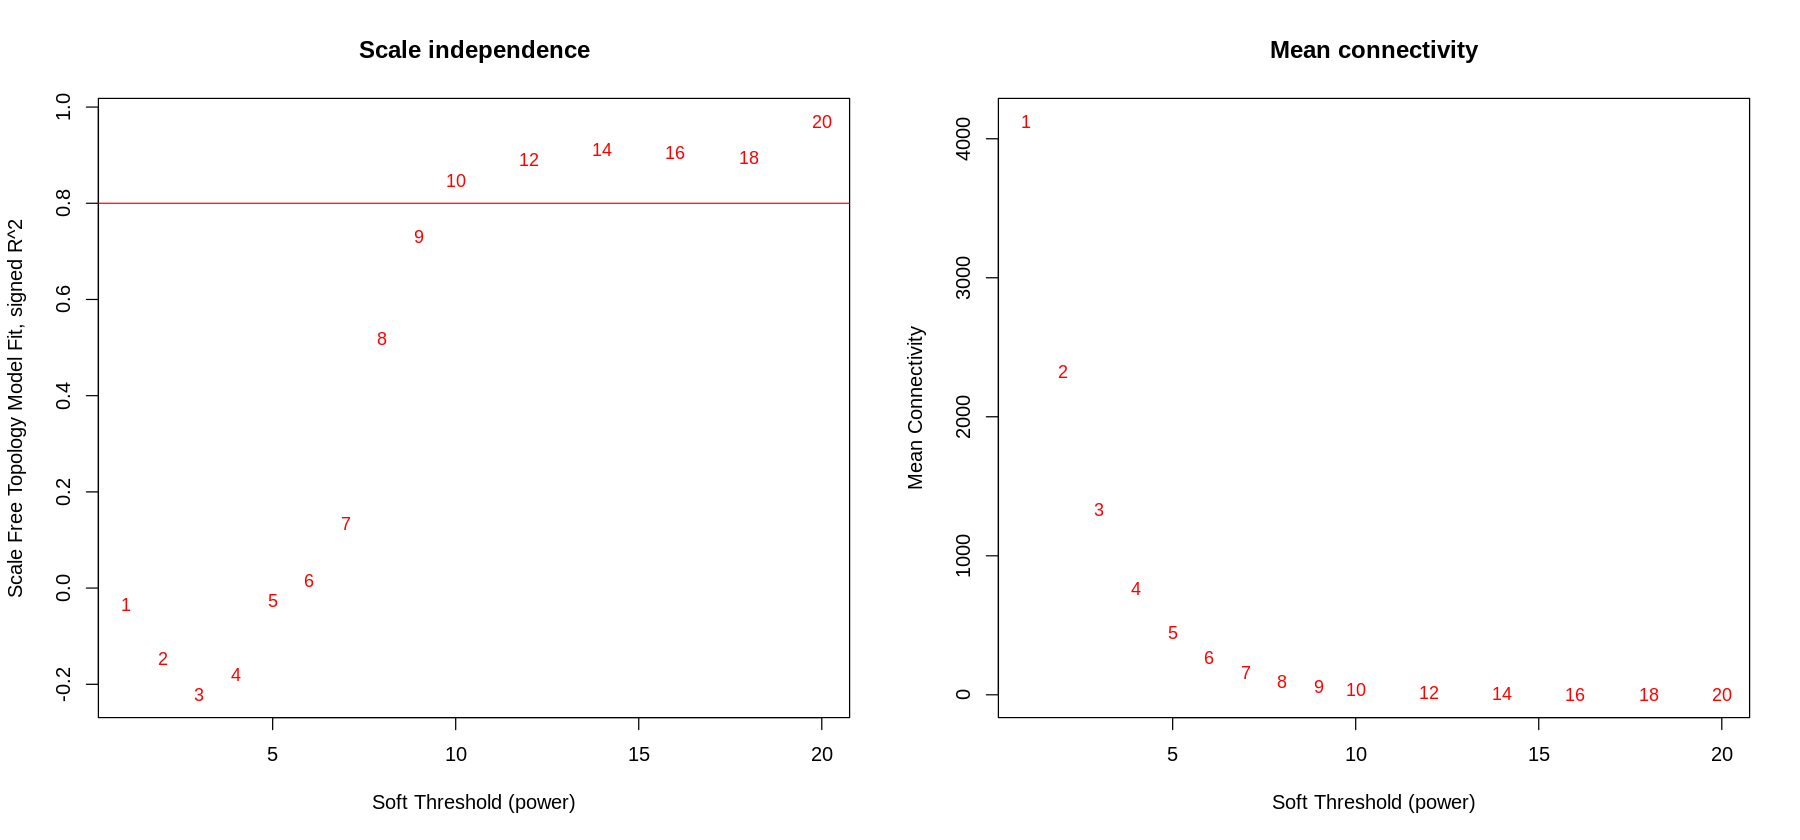

In [99]:
options(repr.plot.width= 15, repr.plot.height = 7)
# Subset to cluster 1 (300 cells)
datExpr = mydata.trans[sc@cpart==1,SubGeneNames]
powers = c(c(1:10), seq(from = 12, to=20, by=2));
sft = pickSoftThreshold(datExpr, dataIsExpr = TRUE, powerVector = powers,
                        corFnc = cor, corOptions = list(use = 'p'), 
                        networkType = "signed")

par(mfrow = c(1,2))
cex1 = 0.9
softPower = 8

plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", 
     ylab="Scale Free Topology Model Fit, signed R^2",
     type="n", main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.80,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)", ylab="Mean Connectivity",
     type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], 
     labels=powers, cex=cex1, col="red")

adj = adjacency(datExpr, type = "signed", power = softPower)
TOM = TOMsimilarityFromExpr(datExpr, networkType = "signed",
                            TOMType = "signed", power = softPower)
colnames(TOM) = rownames(TOM) = SubGeneNames
dissTOM = 1 - TOM

In [100]:
library(WGCNA)
#library(flashClust)

In [102]:
geneTree = hclust(as.dist(dissTOM), method="average");
plot(geneTree, xlab="", sub="",cex=0.3)
minModuleSize = 20;
dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, 
                    guideHang = 0.05, main = "Gene dendrogram and module colors")
options(repr.plot.width= 20, repr.plot.height = 15)
diag(dissTOM) = NA;
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

ERROR: Error in hclust(as.dist(dissTOM), method = "average"): NA/NaN/Inf in foreign function call (arg 11)


Let's try a different cluster... cl4

   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1  0.04440  2.150         0.8180 4110.000  4110.000 4770.0
2      2  0.16500  4.120         0.6520 2290.000  2270.000 3090.0
3      3  0.25600  4.170         0.2390 1280.000  1270.000 2030.0
4      4  0.23000  3.060         0.0120  726.000   707.000 1350.0
5      5  0.12200  1.000         0.0999  415.000   398.000  913.0
6      6  0.00676  0.175         0.8580  240.000   225.000  627.0
7      7  0.01470 -0.270         0.9690  140.000   128.000  438.0
8      8  0.37700 -1.510         0.9240   82.600    73.000  314.0
9      9  0.65200 -2.110         0.9290   49.400    42.000  230.0
10    10  0.83000 -2.550         0.9700   29.900    24.400  171.0
11    12  0.90700 -2.790         0.9770   11.400     8.360   99.4
12    14  0.93600 -2.580         0.9840    4.670     2.940   61.2
13    16  0.94500 -2.350         0.9880    2.050     1.050   39.6
14    18  0.93900 -2.150         0.9800    0.983     0.388   26.8
15    20  

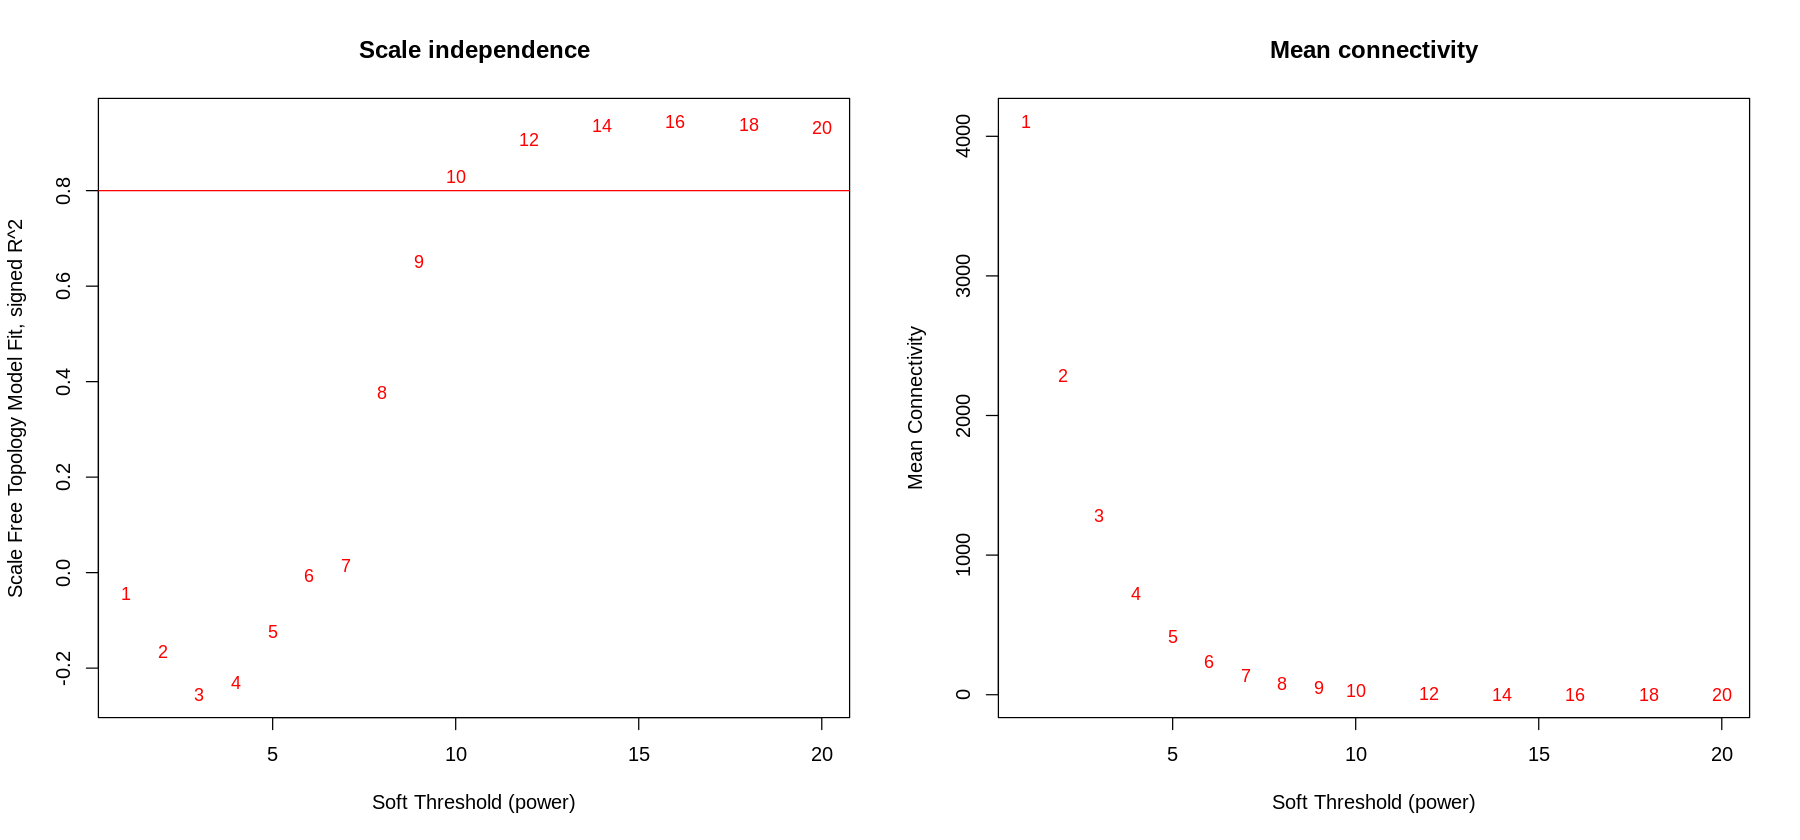

In [103]:
options(repr.plot.width= 15, repr.plot.height = 7)
# Subset to cluster 4 (550 cells)
datExpr = mydata.trans[sc@cpart==4,SubGeneNames]
powers = c(c(1:10), seq(from = 12, to=20, by=2));
sft = pickSoftThreshold(datExpr, dataIsExpr = TRUE, powerVector = powers,
                        corFnc = cor, corOptions = list(use = 'p'), 
                        networkType = "signed")

par(mfrow = c(1,2))
cex1 = 0.9
softPower = 8

plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)", 
     ylab="Scale Free Topology Model Fit, signed R^2",
     type="n", main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=0.80,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)", ylab="Mean Connectivity",
     type="n",main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], 
     labels=powers, cex=cex1, col="red")

adj = adjacency(datExpr, type = "signed", power = softPower)
TOM = TOMsimilarityFromExpr(datExpr, networkType = "signed",
                            TOMType = "signed", power = softPower)
colnames(TOM) = rownames(TOM) = SubGeneNames
dissTOM = 1 - TOM

In [104]:
geneTree = hclust(as.dist(dissTOM), method="average");
plot(geneTree, xlab="", sub="",cex=0.3)
minModuleSize = 20;
dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
table(dynamicMods)
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, 
                    guideHang = 0.05, main = "Gene dendrogram and module colors")
options(repr.plot.width= 20, repr.plot.height = 15)
diag(dissTOM) = NA;
TOMplot(dissTOM^4, geneTree, as.character(dynamicColors))

ERROR: Error in hclust(as.dist(dissTOM), method = "average"): NA/NaN/Inf in foreign function call (arg 11)


same results for cluster 2. Let's see if we can reduce some params

In [111]:
dissTOM[1:5,1:4]

,0610007P14Rik,0610009B22Rik,0610010F05Rik,0610010K14Rik
0610007P14Rik,0,NA,NA,NA
0610009B22Rik,NA,0,NA,NA
0610010F05Rik,NA,NA,0,NA
0610010K14Rik,NA,NA,NA,0
0610012G03Rik,NA,NA,NA,NA


In [114]:
TOM[1:5,1:4]

,0610007P14Rik,0610009B22Rik,0610010F05Rik,0610010K14Rik
0610007P14Rik,1,NA,NA,NA
0610009B22Rik,NA,1,NA,NA
0610010F05Rik,NA,NA,1,NA
0610010K14Rik,NA,NA,NA,1
0610012G03Rik,NA,NA,NA,NA


so the adjacency works, but TOM does not work. Let's see if we can change those params.

In [117]:
TOM = TOMsimilarityFromExpr(datExpr, networkType = "signed",
                            TOMType = "signed Nowick", power = softPower)
#help(TOMsimilarityFromExpr)

TOM calculation: adjacency..
..will use 3 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [118]:
TOM[1:5,1:4]

1,NA,NA,NA
NA,1,NA,NA
NA,NA,1,NA
NA,NA,NA,1
NA,NA,NA,NA


still no improvement -- unclear as to what method to take